# PROBLEMA DE NEGÓCIO

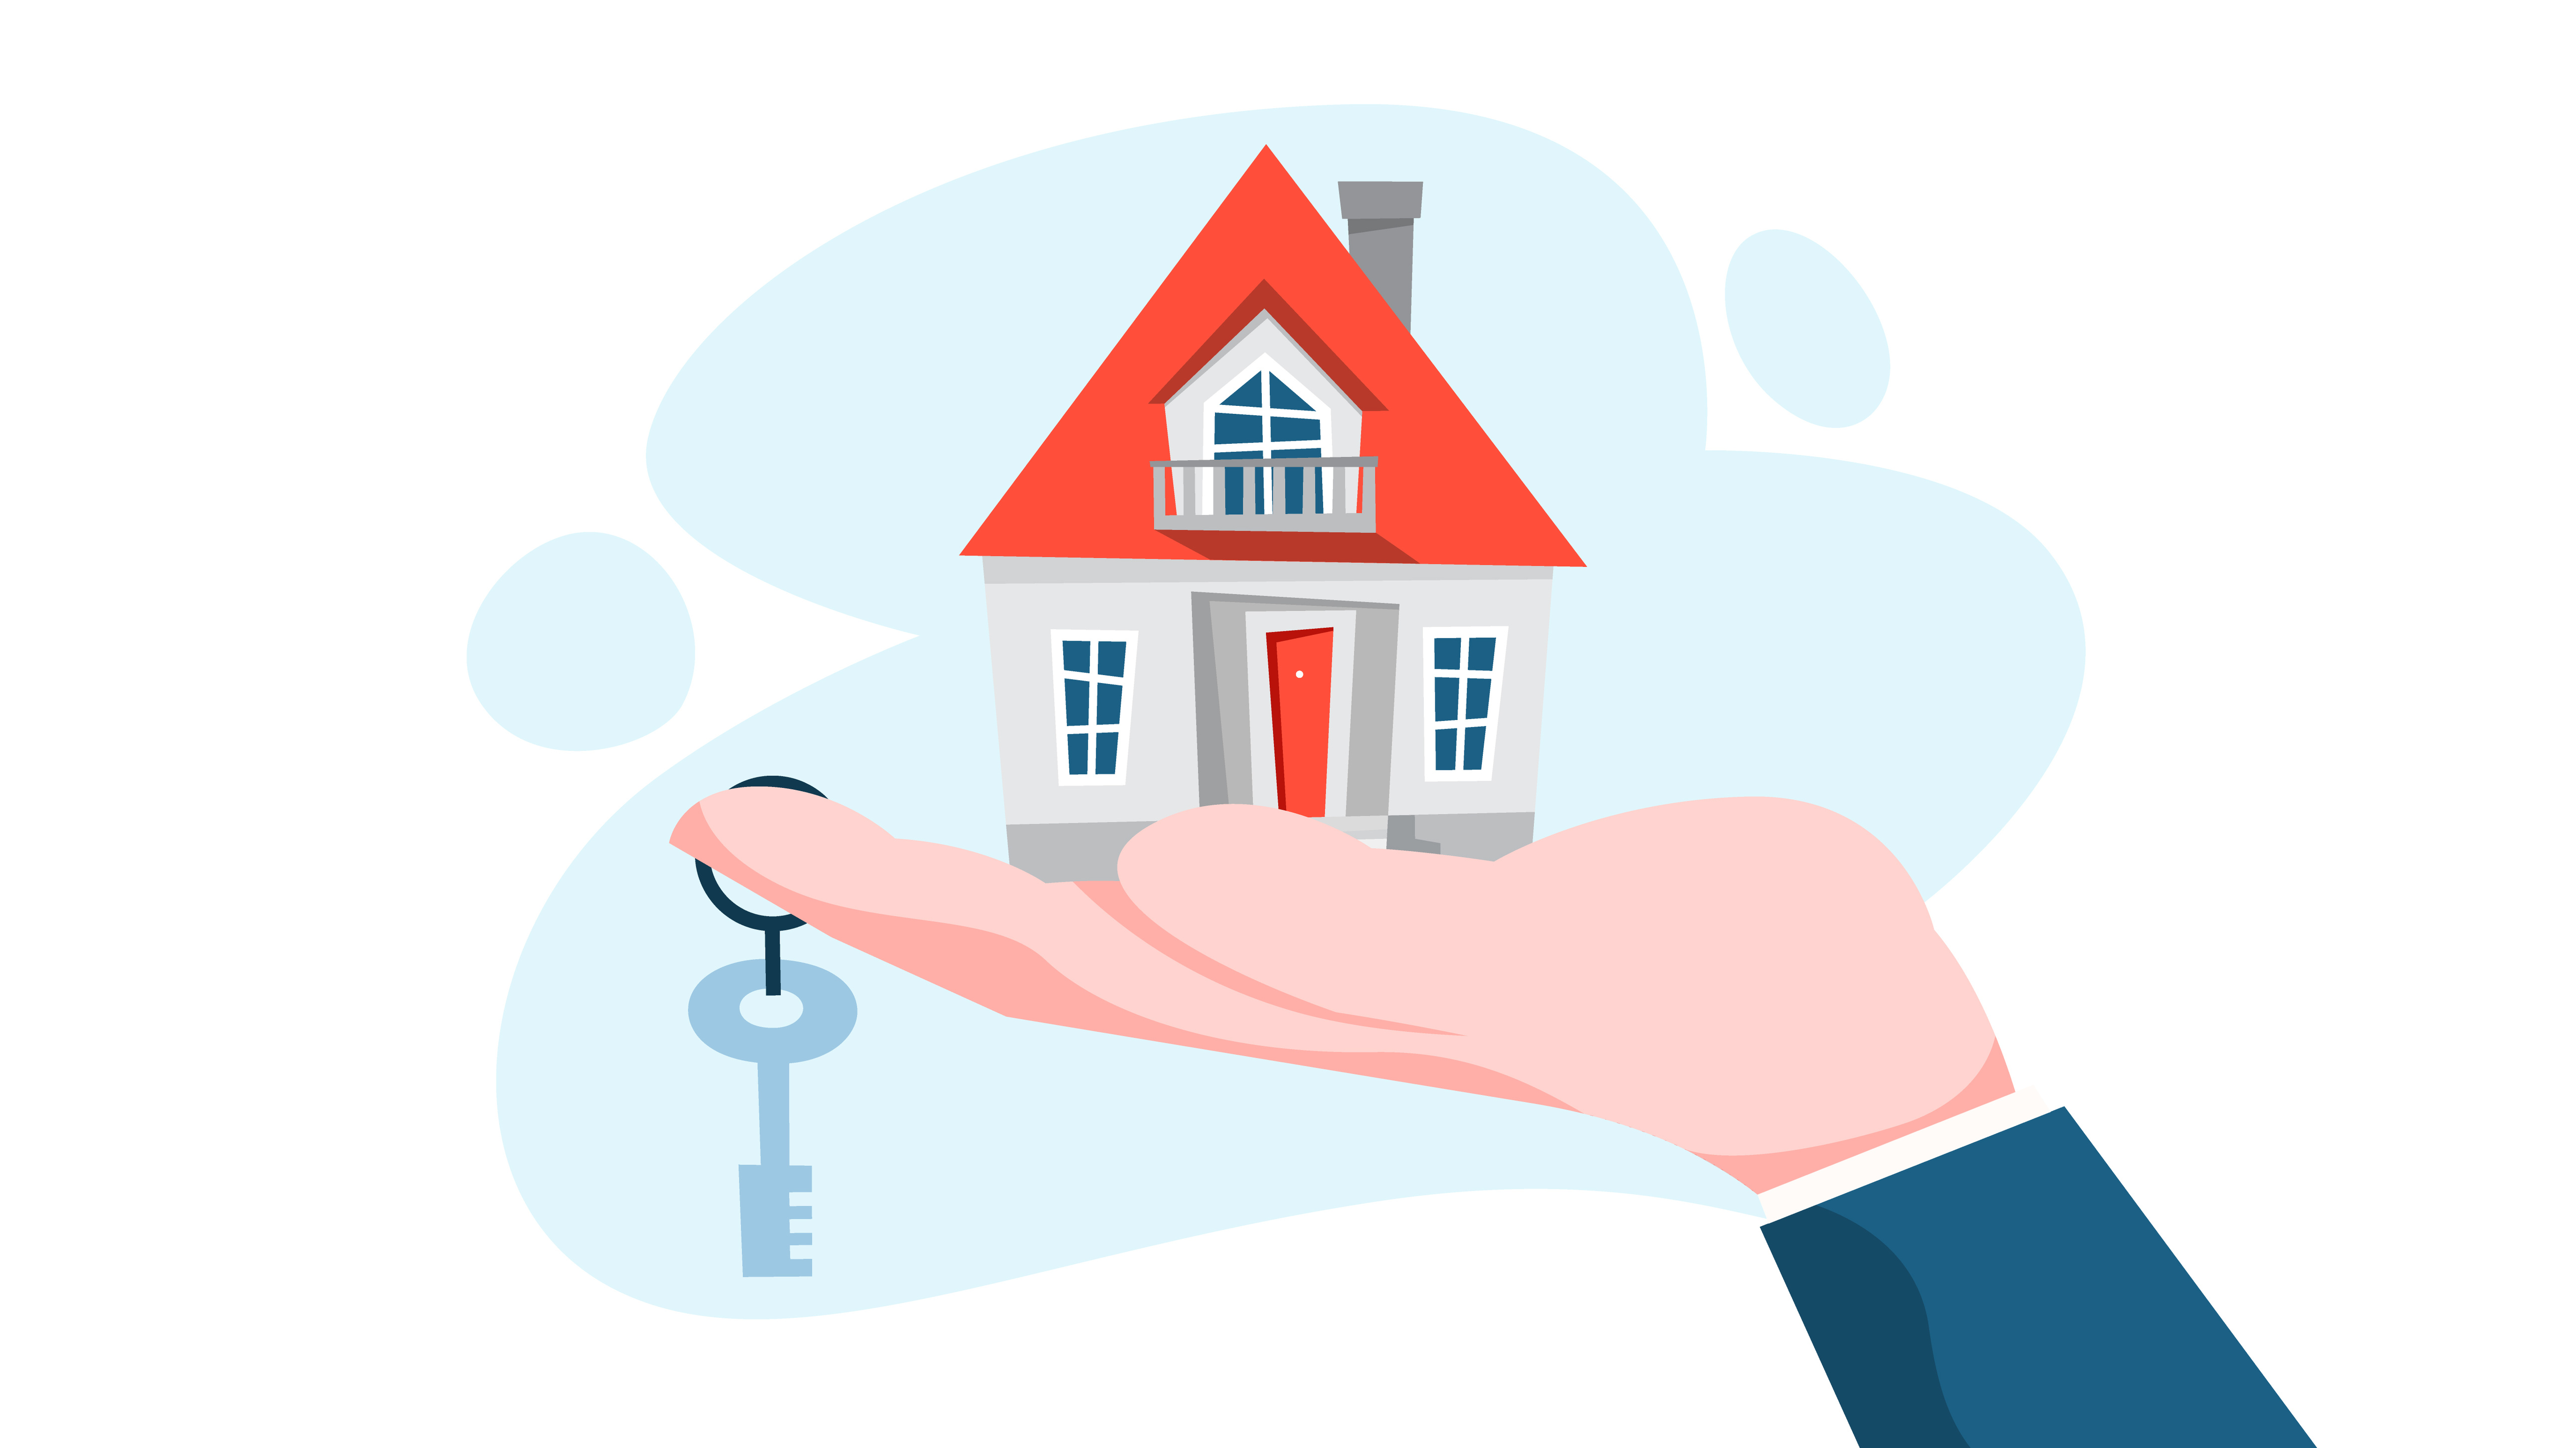

In [29]:
Image("image/capa.jpeg")

Sempre que pensamos em comprar um imóvel, há diversas características que devemos levar em conta, como, quantidade de quartos, banheiros, tamanho e talvez o mais importante: o preço. Afinal, ninguém quer gastar um valor absurdo em um imóvel e depois descobrir que há um melhor e com preço reduzido. Mas hoje através de técnicas de Ciência de Dados e Machine Learning, já é possível não só prever o preço como também otimizar os retornos financeiros.

E para um fundo imobiliário que precisa medir o ROI, obter as informações necessárias, como conhecer as características dos imóveis, é essencial antes de iniciar um novo business. E você pode estar agora se perguntando: mas como todos esses dados influenciam no preço do imóvel? Para explicar essa premissa, resolveremos o seguinte problema.

## Contexto

Este projeto tem como objetivo precificar imóveis, o qual faz parte da seleção de Estágio para Cientistas de Dados. Todos os dados foram fornecidos pela empresa e será mostrado durante o desenvolvimento da solução. Portanto, iremos dividir as etapas em:

- **0.0** IMPORTS
- **1.0** DATA DESCRIPTION
- **2.0** FEATURE ENGINEERING
- **3.0** EXPLORATORY DATA ANALYSIS
- **4.0** DATA PREPARATION
- **5.0** FEATURE SELECTION
- **6.0** MACHINE LEARNING ALGORITHMS
- **7.0** HYPERPARAMETER FINE TUNING
- **8.0** PERFORMANCE ANALYSIS
- **9.0** DEPLOY MODEL TO PRODUTION

# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,RandomizedSearchCV
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow import keras

from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats
#import xgboost             as xgb
import warnings
from boruta import BorutaPy
import pickle

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))


def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cross_validation( X, y , kfold, model_name, model, verbose=True ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

        # model
        m = model.fit( X_train, y_train )

        # prediction
        yhat = m.predict( X_test )

        # performance
        m_result = ml_error( model_name, np.expm1( y_test ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

Antes de ler os dados, nos foram fornecidos as seguintes informações

- Zona: Classificação da zona de venda
		
       RL	Zona residencial de baixa densidade
       RM	Zona residencial de média densidade

- Area: Tamanho do terreno (pés quadrados)

- Qualidade: Qualidade do material e acabamento do imóvel

- AnoConstrucao: Data de construção

- QualidadeAquecimento: Qualidade do sistema de aquecimento

       Ex	Excelente
       Gd	Bom
       TA	Mediano
       Fa	Aceitável

- Banheiros: Banheiros

- Quartos_t1: Quartos tipo 1

- Quartos_t2: Quartos tipo 2
      	
- Comodos: Total de cômodos
		
- Lareiras: Quantidade de lareiras
		
- Garagem: Tamanho da garagem em termos de quantidade de carros

- Preco: Preço de venda do imóvel

In [4]:
#lendo arquivo csv utilizando o pandas
df_raw = pd.read_csv("data/Desafio2_input.csv", sep = ';')

In [5]:
columns = ['Id', 'Zona', 'Area', 'Qualidade', 'AnoConstrucao',
       'QualidadeAquecimento', 'Banheiros', 'Quartos_t1', 'Quartos_t2',
       'Comodos', 'Lareiras', 'Garagem', 'Preco']

Antes de começar de fato a construir a nossa solução, vmaos dar uma olhada nas 5 primeiras linhas do nosso dataset. 

In [6]:
#print 5 first rows
df_raw.head()

,Id,Zona,Area,Qualidade,AnoConstrucao,QualidadeAquecimento,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000


# 1.0. DATA DESCRIPTION

Em cada etapa, iremos realizar um cópia do dataframe. Isso nos permitirá, caso precise realizar alguma modificação, evitar que todo o script tenha que ser rodado novamente.

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
#extraindo colunas do dataframe
df1.columns

Index(['Id', 'Zona', 'Area', 'Qualidade', 'AnoConstrucao',
       'QualidadeAquecimento', 'Banheiros', 'Quartos_t1', 'Quartos_t2',
       'Comodos', 'Lareiras', 'Garagem', 'Preco'],
      dtype='object')

In [9]:
#colunas extraidas do dataframe
columns = ['Id', 'Zona', 'Area', 'Qualidade', 'AnoConstrucao',
       'QualidadeAquecimento', 'Banheiros', 'Quartos_t1', 'Quartos_t2',
       'Comodos', 'Lareiras', 'Garagem', 'Preco']

#lista vazia para armazerar o nome das novas colunas
new_columns = []

#loop for para transformar cada columa em lowercase
for each_column in columns:
    new_columns.append(each_column.lower())
    
#mudando nome das colunas
df1.columns = new_columns

In [10]:
#verificando novamente as 5 primeiras colunas
df1.head()

,id,zona,area,qualidade,anoconstrucao,qualidadeaquecimento,banheiros,quartos_t1,quartos_t2,comodos,lareiras,garagem,preco
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000


## 1.2. Data Dimensions

Para que possamos de fato resolver o nosso problema, precisamos saber se possuímos poder computacional suficiente ou até mesmo se possuímos dados suficentes para que nosso modelo de machine learning possa aprender. Portanto, entender qual a dimensão dos dados é fundamental. 

In [11]:
#verificando shape do dataframe
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 629
Number of columns: 13


Como visto acima, possuímos 629 linhas e 13 colunas. É importante observar que possuímos poucos dados, portanto,conseguiremos realizar a compilação do algoritmo em nossa máquina local. No entanto, é necessário levar em consideração que talvez não tenhamos dados suficientes para treinar o modelo com algoritmos de machine learning tradicional, para isso, muitas vezes se utiliza inferência bayseana. 

## 1.3. Data Types

Esta etapa é importante para entendermos qual é o tipo de nossos recursos. Portanto, precisamos tratar cada variável de acordo com seu tipo específico ... por exemplo, não podemos tratar uma data como um número ou como um texto, não podemos tratar um número como um texto. É necessário que entendamos o contexto do nosso negócio para que as mudanças sejam feitas.

In [12]:
#checking types
df1.dtypes

id                       int64
zona                    object
area                     int64
qualidade                int64
anoconstrucao            int64
qualidadeaquecimento    object
banheiros                int64
quartos_t1               int64
quartos_t2               int64
comodos                  int64
lareiras                 int64
garagem                  int64
preco                    int64
dtype: object

Como visto acima, não possuímos nenhum tipo de dados inconsistente. 

In [13]:
#print first five rows
df1.head()

,id,zona,area,qualidade,anoconstrucao,qualidadeaquecimento,banheiros,quartos_t1,quartos_t2,comodos,lareiras,garagem,preco
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000


## 1.4. Check NA

Essa etapa é extremamente importante porque alguns dos nossos algoritmos de machine learning não são capazes de manipular valores nulos. Para resolver este problema, não existe uma resposta certa, vai depender do seu contexto de negócio.Temos que estar atentos e testar o que mais se adequa a essa situação. Existem três maneiras de corrigir isso.

- Exclua linhas com valores nulos.
- Substitua pela média ou mediana, por exemplo.
- Mude de acordo com o contexto do negócio.

Esta escolha é muito importante porque, se escolhermos excluir as linhas de nosso conjunto de dados, dependendo da quantidade de valores nulos, iremos eliminar uma quantidade considerável de dados para que nosso modelo possa treinar.

In [14]:
df1.isnull().sum()

id                      0
zona                    0
area                    0
qualidade               0
anoconstrucao           0
qualidadeaquecimento    0
banheiros               0
quartos_t1              0
quartos_t2              0
comodos                 0
lareiras                0
garagem                 0
preco                   0
dtype: int64

Como visto acima, não possuimos nenhum valor nulo. Portanto, não será necessário realizar nenhuma alteração. 

## 1.5. Descriptive Statistical

Esta etapa é essencial. É necessário separar as variáveis numéricas das variáveis categóricas. Porque cada um terá uma forma diferente de análise.

In [15]:
#num attributes and categorical attributes
num_attributes = df1.select_dtypes(exclude = ['object'])
cat_attributes = df1.select_dtypes(include = ['object'])

### 1.5.1. Numerical Attributes

Para as variáveis numéricas, usamos dois tipos de análise.

- Tendencia central

    - média
    - mediana

- Dispersão

    - std - desvio padrão
    - min
    - max
    - range
    - skew
    - kurtosis

In [16]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,629.0,628.0,315.000000,315.0,181.576430,0.000000,-1.200000
1,area,1300.0,19900.0,18600.0,8932.025437,9000.0,3316.246262,0.057135,0.792918
2,qualidade,4.0,8.0,4.0,5.642289,6.0,0.892038,0.199610,-0.398322
3,anoconstrucao,1940.0,2009.0,69.0,1974.421304,1971.0,19.174678,0.271105,-1.069629
4,banheiros,1.0,2.0,1.0,1.370429,1.0,0.482920,0.537898,-1.716133
5,quartos_t1,1.0,3.0,2.0,2.651828,3.0,0.550690,-1.309338,0.748155
6,quartos_t2,2.0,4.0,2.0,3.651828,4.0,0.550690,-1.309338,0.748155
7,comodos,3.0,8.0,5.0,5.782194,6.0,1.039109,-0.143068,0.029603
8,lareiras,0.0,2.0,2.0,0.515103,0.0,0.600882,0.713116,-0.455810
9,garagem,0.0,3.0,3.0,1.608903,2.0,0.577520,-0.829227,0.125455


Da tabela acima, precisamos observar alguns pontos.

- **area** -> o menor valor é 1300 e sua média é 8900. Se observamos a mediana, 50% dos dados possuem area maior ou igual a 9000 pés
- **qualidade** -> esta variável está sendo classificada com numérica, no entanto, acredito que poderemos verificá-la melhor na análise de variável categórica. Do ponto de vista numérico, não conseguimos extrair muitas informações relevantes.
- **anoconstrucao** -> O imóvel mais antigo foi construído em 1940, mas é importante verificar que na média,os imóvies foram construídas em 1974 e 50% foram construídos após 1971.
- **banheiros** -> máximo de banheiros = 2
- **lareiras** -> menor valor é igual a zero, podemos inferir que este imóvel não possui lareira. 
- **garagem** -> menor valor igual a 1, podemos inferir que este imóvel não possui garagem.
- **preco** -> imóvel mais barato custa  80.000, mas em média, custa-se aproximadamente 148.000. 50% dos imóveis custam acima de 147.000.

### 1.5.2 Categorical Attributes

Para variáveis categóricas, usaremos o boxplot, que fornece uma análise visual da posição, dispersão, simetria e outliers do conjunto de dados.

In [17]:
#check 5 five rows
cat_attributes.head()

,zona,qualidadeaquecimento
0,RL,Ex
1,RL,Ex
2,RL,Ex
3,RL,TA
4,RL,TA


Como visto na etapa acima, a variável qualidade pode ser avaliada como categórica, visto que ela representa um comportamento ordinal. Sendo assim, iremos includir no dataset

In [18]:
#selecionando as colunas
cat_attributes = df1[['zona',"qualidadeaquecimento","qualidade"]]

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

zona                    2
qualidadeaquecimento    4
qualidade               5
dtype: int64

No boxplot abaixo, podemos tirar algumas conclusões:

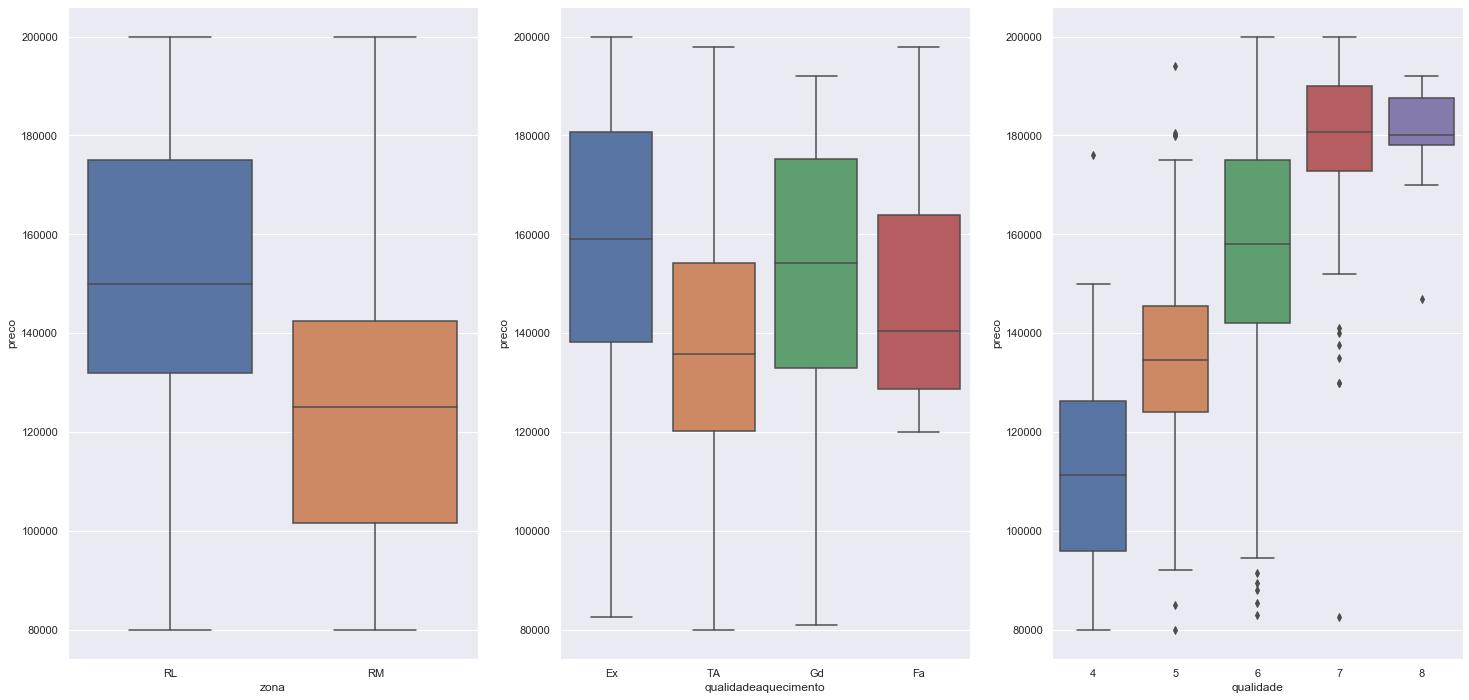

In [20]:
#zona
plt.subplot(1,3,1)
sns.boxplot(x = "zona", y = "preco", data = df1);

#qualidade de aquecimento
plt.subplot(1,3,2)
sns.boxplot(x = "qualidadeaquecimento", y = "preco",data = df1);

#qualidade
plt.subplot(1,3,3)
sns.boxplot(x = "qualidade", y = "preco", data = df1);

A partir dos boxplot acima, podemos tirar algumas conclusões

- Zona 
    - Imóveis que estão em zonas residenciais com baixa densidade, em média, são mais caros. 
    
- qualidade de aquecimento
    - Imóveis de qualidade excelente e bom, costumam ser mais caros. Observe que a mediana deles está bem próxima. 
    - Já os imóveis de qualidade aceitável tendem a ser mais baratos. O seu 3º quartil está próxima do 2º quartil dos imóveis com excelente e boa qualidade. 
    
- qualidade
    - Conseguimos observar uma tendência crescente da qualidade em relação aos preços.
    - Observe que imóveis com qualidade 7 e 8 possuem mediana praticamente igual, no entanto, os de qualidade 8 então mais concetrados em um intervalo menor. 

# 2.0. FEATURE ENGINEERING

In [21]:
#copiando dataframe
df2 = df1.copy()

## 2.1. MindMap Hypothesis

Para compor essa etapa, criamos uma hipótese de mapa mental. É uma ferramenta fácil de visualizar todas as opiniões sobre o nosso contexto de negócios. Então, vamos criar alguns recursos que serão úteis na análise exploratória de dados e para obter alguns insights, úteis para entender qual é a influência de cada variável em nossa variável de predição. Esta etapa é útil para ter dados organizados. Portanto, precisamos responder a algumas perguntas:

- Quais features serão necessários para validar cada hipótese?
- Qual é o fenômeno que estamos modelando?
    - Preço de Imóveis
- Quais a descrição dos agentes que envolve o preço do imóvel?

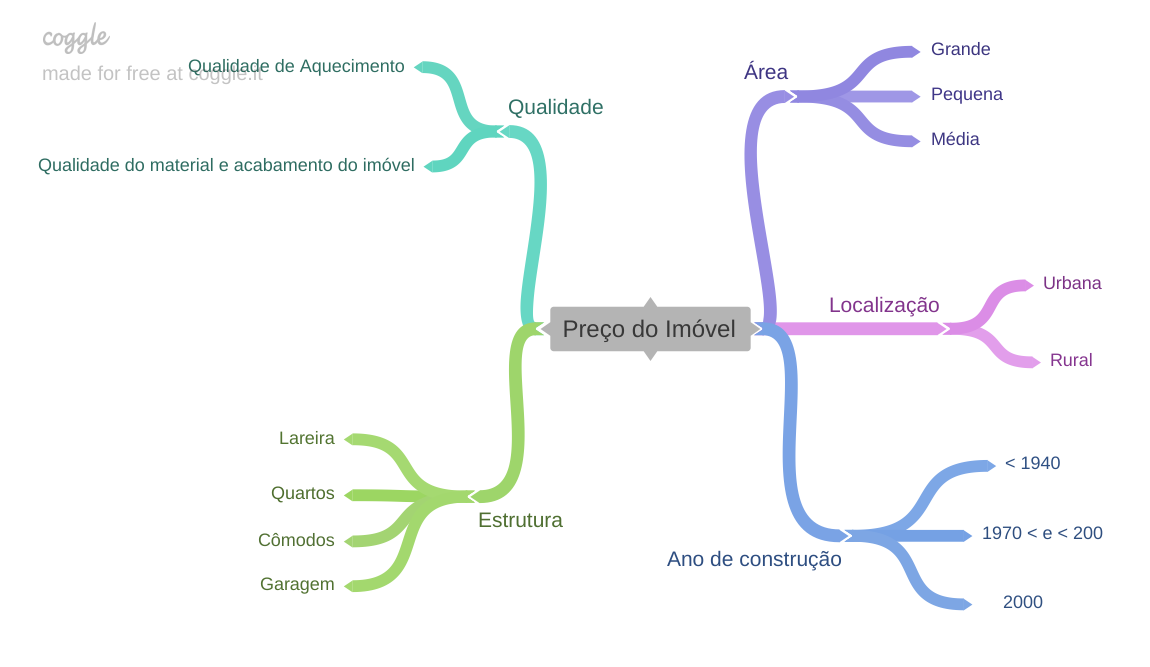

In [22]:
Image("image/mindmap.png")

## 2.2. Lista de Hipóteses

- **H1** Imóveis com maior área devem ser mais caras.


- **H2** Imóveis mais novos devem ser mais caros. 


- **H3** Imóveis localizados em regiões mais populosas devem ser mais caros. 


- **H4** Imóveis que possuem garagem devem ser mais caros.


- **H5** Imóveis com mais cômodos devem ser mais caros.


- **H6** Imóveis com mais quartos devem ser mais caros 


- **H7** Imóveis com possuem lareira devem ser mais caros.


- **H8** Imóveis com excelente qualidade de acabamento devem ser mais caros.


- **H9** Imóveis com boa qualidade de material e acabamento devem ser mais caros.

## 2.3. Feature Engineering

Para validar nossas hipóteses só modificaremos os valores das variáveis categóricas para ficar de fácil entendimento. 

In [23]:
#qualidade de aquecimento
df2['qualidadeaquecimento'] = df2['qualidadeaquecimento'].apply(lambda x:"Excelente" if x == "Ex" else "Bom" if x == "Gd" else "Mediano" if x == "TA" else "Aceitável")

#zona
df2['zona'] = df2['zona'].apply(lambda x: "Zona de baixa densidade" if x == "RL" else "Zona de média densidade")

In [24]:
#print 5 primeiras linhas do dataframe
df2.head()

,id,zona,area,qualidade,anoconstrucao,qualidadeaquecimento,banheiros,quartos_t1,quartos_t2,comodos,lareiras,garagem,preco
0,1,Zona de baixa densidade,9600,6,1976,Excelente,2,3,4,6,1,2,181500
1,2,Zona de baixa densidade,14115,5,1993,Excelente,1,1,2,5,0,2,143000
2,3,Zona de baixa densidade,11200,5,1965,Excelente,1,3,4,5,0,1,129500
3,4,Zona de baixa densidade,12968,5,1962,Mediano,1,2,3,4,0,1,144000
4,5,Zona de baixa densidade,10920,6,1960,Mediano,1,2,3,5,1,1,157000


# 3.0. EXPLORATORY DATA ANALYSIS

Análise Exploratória de Dados (EDA) é o processo de visualização e análise de dados para extrair insights deles. Em outras palavras, EDA é o processo de resumir características importantes dos dados para obter uma melhor compreensão do conjunto de dados. Portanto, esta parte será feita nas três etapas a seguir:

- Análise Univariada
- Análise Bivariada
- Análise multivariada

## 3.1. Análise Univariada

In [25]:
df3 = df2.copy()

### 3.1.1. Response Variable

Construímos um distplot para ver como nossa variável de resposta é distribuída. É importante entender que aprendizado de máquina, função de custo ou valores de potencial de um neurônio são as quantidades que se espera serem a soma de muitos processos independentes (como recursos de entrada ou potencial de ativação da última camada) frequentemente têm distribuições que são quase normais.

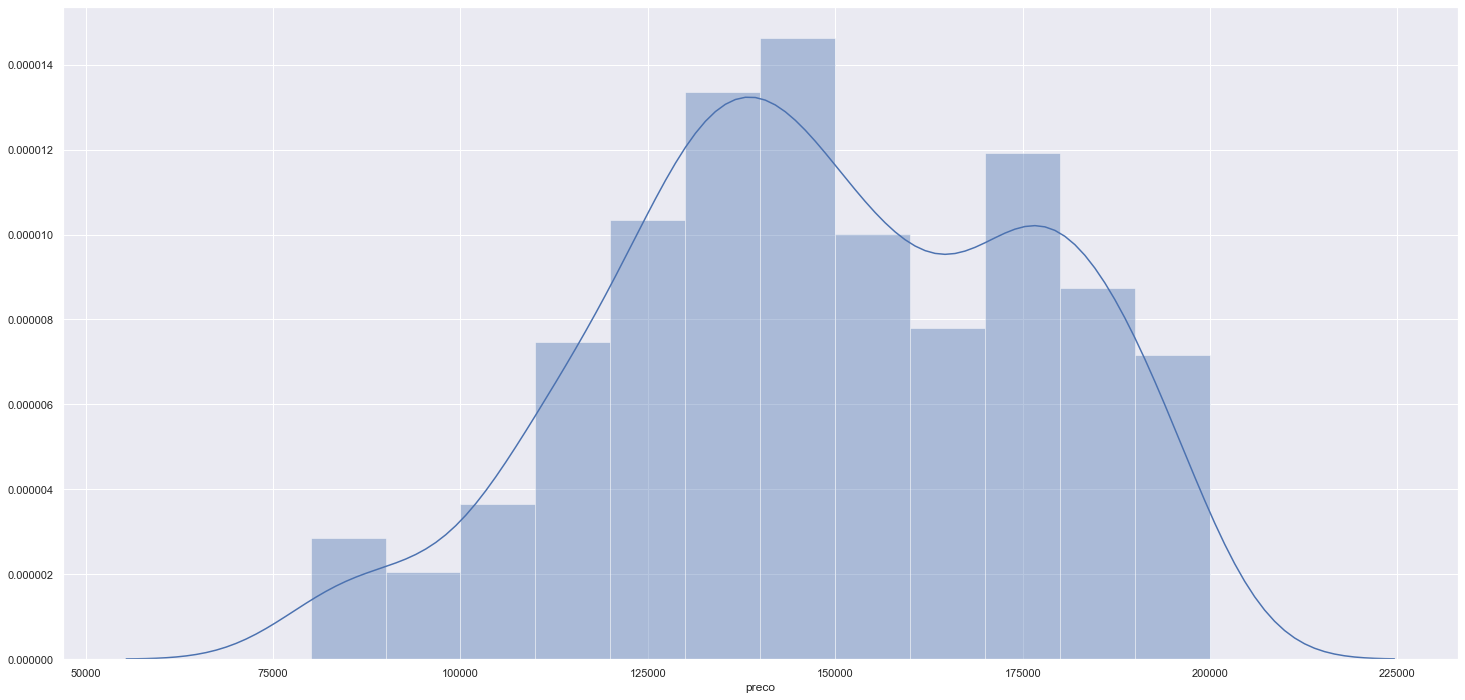

In [111]:
sns.distplot(df1['preco'])

A partir do gráfico de dispersão acima, conseguimos ver um comportamento especifico. Nossa variável possui uma distribuição próximo da normal, exceto pela existência de um máximo local com valor de 175000.

### 3.1.2. Numerical Variables

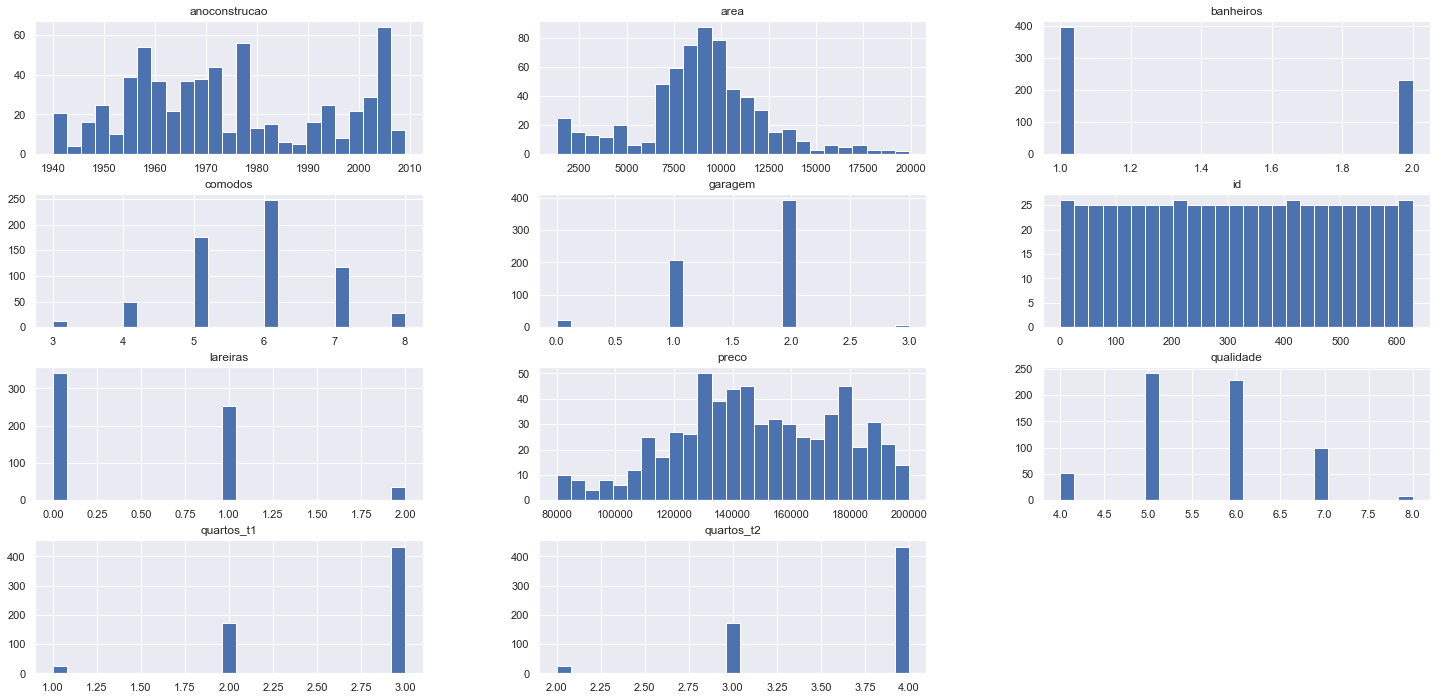

In [112]:
num_attributes = df3.select_dtypes(exclude = ["object"])
num_attributes.hist(bins = 25);

- **anoconstrucao** -> maior concetração de imóveis construídos entre 1950 e 1980. Pouco antes de 2010, houve um pico muita grande construção de imóveis.

- **area** -> Maior concetração entre aproximadamente 7500 e 12500.

- **banheiro** -> Há mais imóveis com apenas 1 banheiro do que com 2.

- **comodos** -> imóveis com máximo de cômodos e mínimos de cômodos não prevalecem. Observa-se alta quantidade nos que possuem 6 cômodos.

- **garagem** -> Há mais imóveis com disponibilidade de 2 carros na garagem.

- **quartos_t1 e quartos_t2** -> Há mais imóveis com a quantidade máxima de quartos.

- **preco** -> Analisamos na secção anterior. Possui distribuição próximo de uma normal.

- **qualidade** -> Há mais imóveis de qualidade 5.

### 3.1.2 Categorical Variables

In [113]:
#select only necessary variables
cat_attributes = df3[["zona","qualidadeaquecimento","qualidade"]]

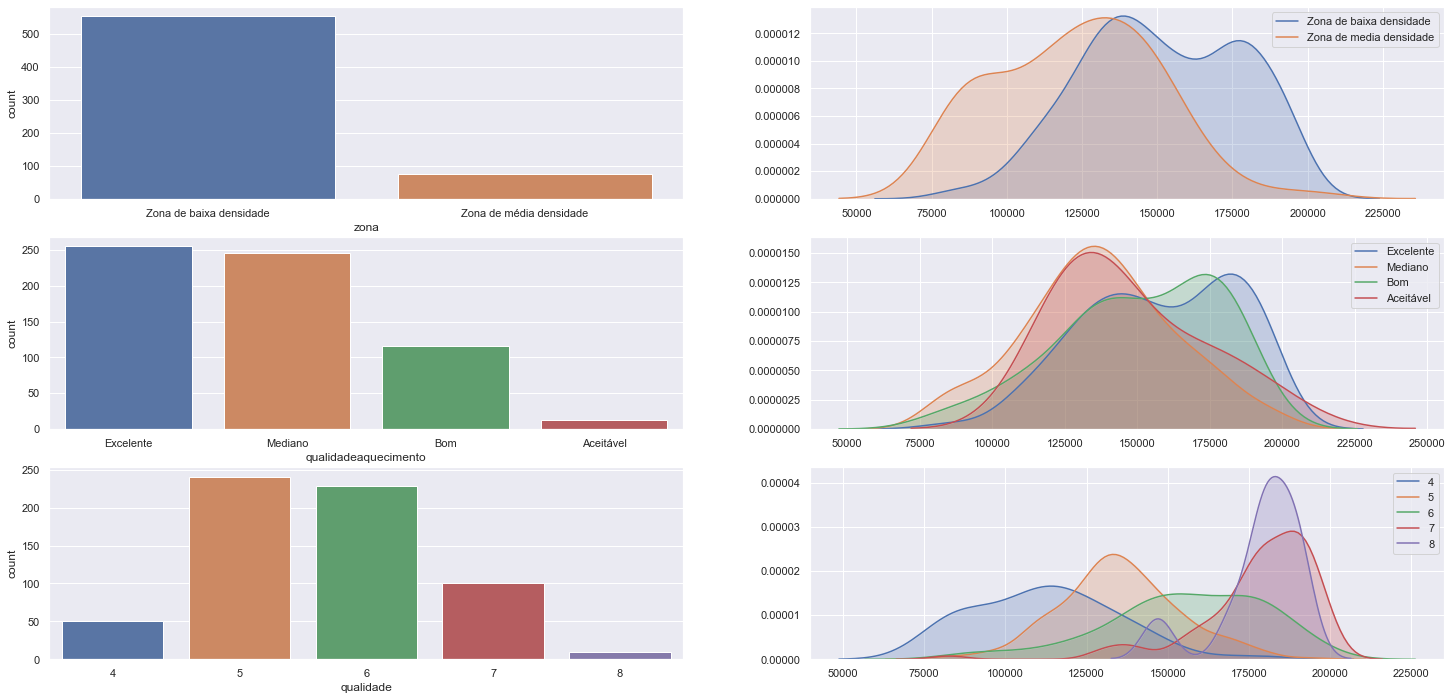

In [114]:
plt.subplot(3,2,1)
sns.countplot(cat_attributes["zona"])

plt.subplot(3,2,2)
sns.kdeplot(df3[df3["zona"] == "Zona de baixa densidade"]["preco"], label = "Zona de baixa densidade", shade = True)
sns.kdeplot(df3[df3["zona"] == "Zona de média densidade"]["preco"], label = "Zona de media densidade", shade = True)


plt.subplot(3,2,3)
sns.countplot(df3['qualidadeaquecimento'])

plt.subplot(3,2,4)
sns.kdeplot(df3[df3["qualidadeaquecimento"] == "Excelente"]['preco'], label = "Excelente", shade = True)
sns.kdeplot(df3[df3["qualidadeaquecimento"] == "Mediano"]['preco'], label = "Mediano", shade = True)
sns.kdeplot(df3[df3["qualidadeaquecimento"] == "Bom"]['preco'], label = "Bom", shade = True)
sns.kdeplot(df3[df3["qualidadeaquecimento"] == "Aceitável"]['preco'], label = "Aceitável", shade = True)

plt.subplot(3,2,5)
sns.countplot(df3["qualidade"])

plt.subplot(3,2,6)
sns.kdeplot(df3[df3["qualidade"] == 4]['preco'], label = "4", shade = True)
sns.kdeplot(df3[df3["qualidade"] == 5]['preco'], label = "5", shade = True)
sns.kdeplot(df3[df3["qualidade"] == 6]['preco'], label = "6", shade = True)
sns.kdeplot(df3[df3["qualidade"] == 7]['preco'], label = "7", shade = True)
sns.kdeplot(df3[df3["qualidade"] == 8]['preco'], label = "8", shade = True)

- **zona** -> Há muito mais imóveis em zonas de baixa densidade. Observa-se também que estes costumam ser mais caros em relação aos de média densidade.

- **qualidade de aquecimento** -> Imóvies do tipo excelente e médiano são os mais comuns. No entanto, os do tipo excelente e bom são os mais valorizados, possuindo uma distribuição muito parecida. A distribuição dos imóveis medianos e aceitáveis também é bastante parecida, próximo de uma distribuição normal.

- **qualidade** -> Possuímos maior quantidade de imóveis com qualidade 5 e 6. No entanto, os mais valorizados são os 7 e 8. 

## 3.2. Análise Bivariada

- **H1** Imóveis com maior área devem ser mais caras.


- **H2** Imóveis mais novos devem ser mais caros. 


- **H3** Imóveis localizados em regiões mais populosas devem ser mais caros. 


- **H4** Imóveis que possuem garagem devem ser mais caros.


- **H5** Imóveis com mais cômodos devem ser mais caros.


- **H6** Imóveis com mais quartos devem ser mais caros 


- **H7** Imóveis com possuem lareira devem ser mais caros.


- **H8** Imóveis com excelente qualidade de acabamento devem ser mais caros.


- **H9** Imóveis com boa qualidade de material e acabamento devem ser mais caros.

### **H1** Imóveis com maior área devem ser mais caras.

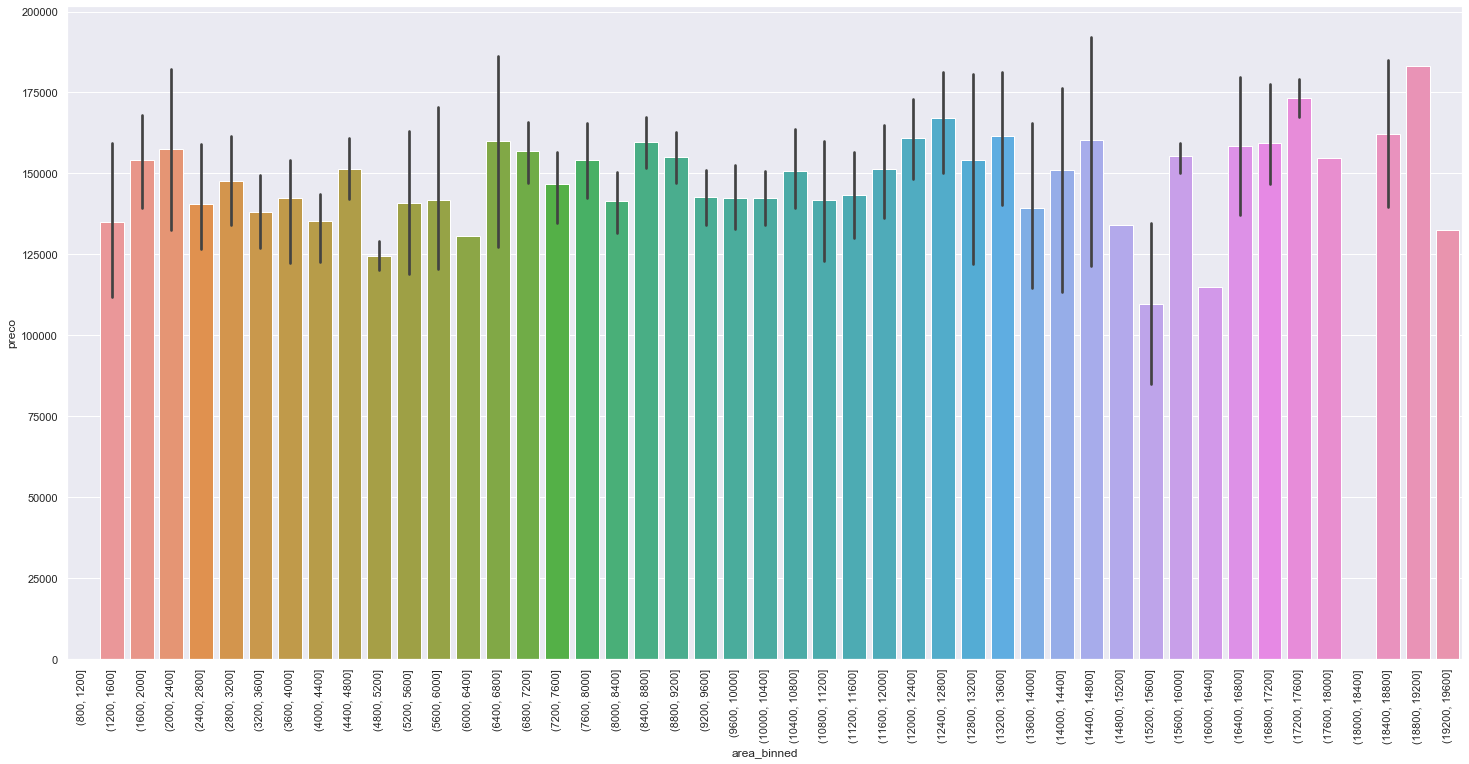

In [115]:
#groupby
aux = df3[["area","preco"]].groupby("area").mean().reset_index()


bins = list(np.arange(800,20000,400))
aux["area_binned"] = pd.cut(df3["area"], bins = bins )

sns.barplot(x = "area_binned",y = "preco", data = aux)
plt.xticks(rotation = 90);

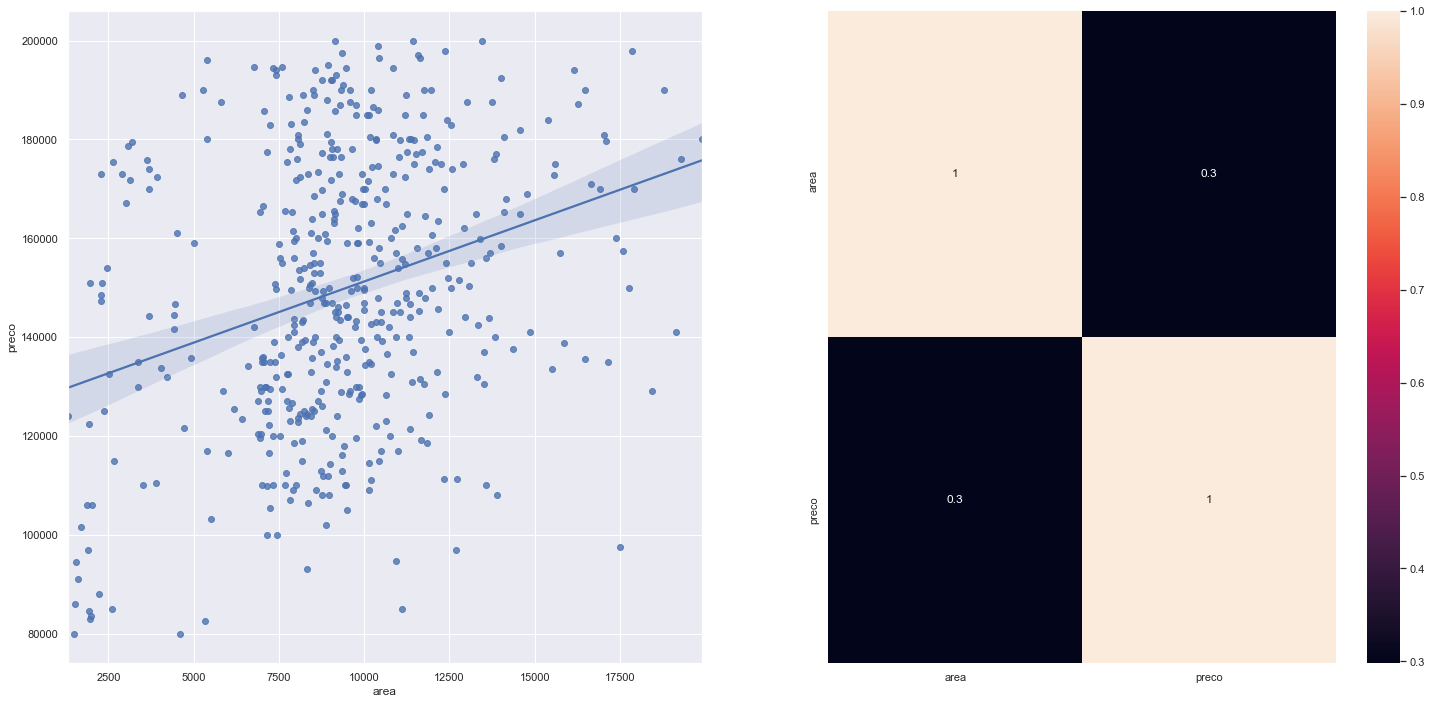

In [116]:
plt.subplot(1,2,1)
sns.regplot(x = "area", y = "preco", data = aux)

plt.subplot(1,2,2)
sns.heatmap(df3[["area","preco"]].corr(method = "pearson"), annot = True)

- No gráfico de barras não conseguimos tirar muitas conclusões, no entanto, quando olhamos para o gráfico de dispersão vemos uma correlação positiva entre a área e o preço do imóvel.

- Possui uma correlação positiva, porém fraca. 

- Acredito que a área possa combinar com outra variável para gerar uma correlação maior. 

- A hipótese é verdadeira, exceto em alguns imóveis que apesar de possuir uma área maior, o preço é menor. É provável que outra variável faça com que o preço aumente ou diminua. 

### **H2** Imóveis mais novos devem ser mais caros.

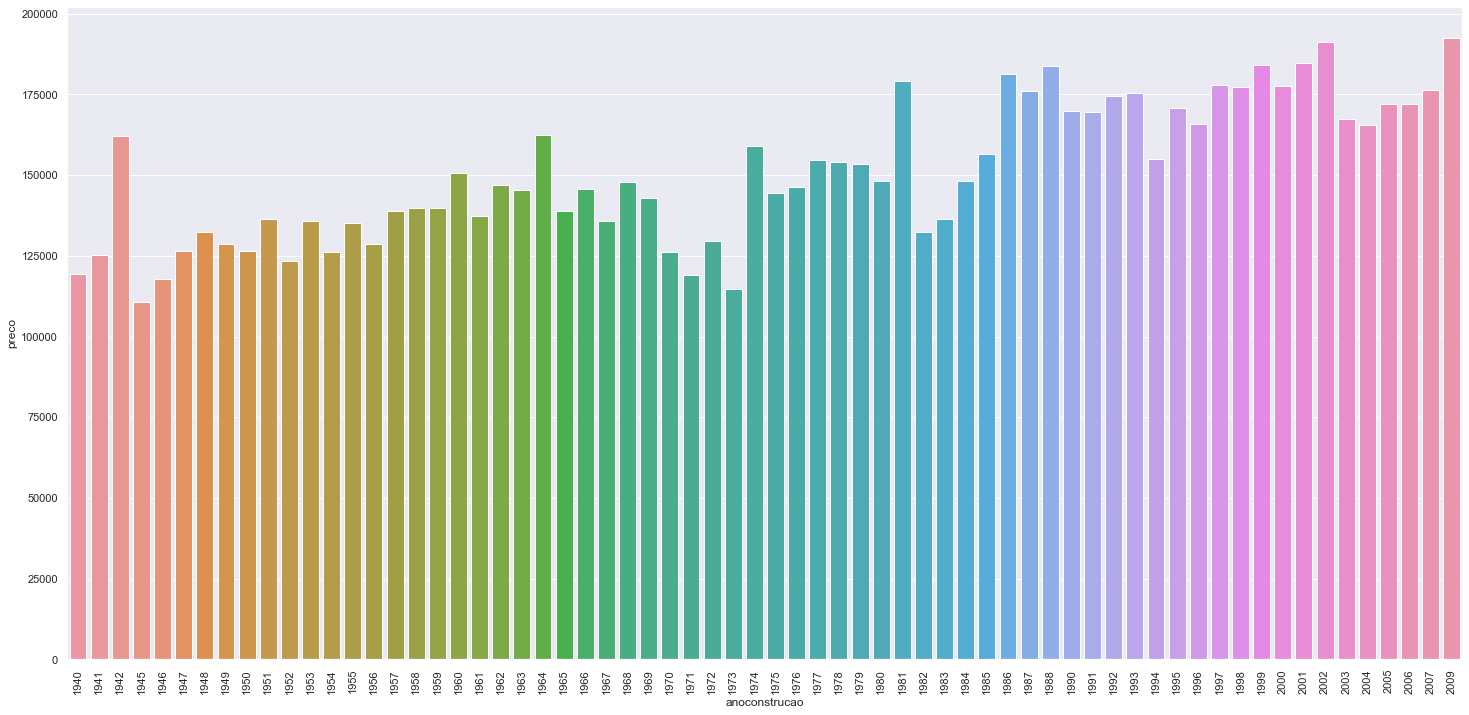

In [117]:
aux = df3[["anoconstrucao","preco"]].groupby("anoconstrucao").mean().reset_index()

#barplot
sns.barplot(x = "anoconstrucao", y = "preco", data = aux)
plt.xticks(rotation = 90);

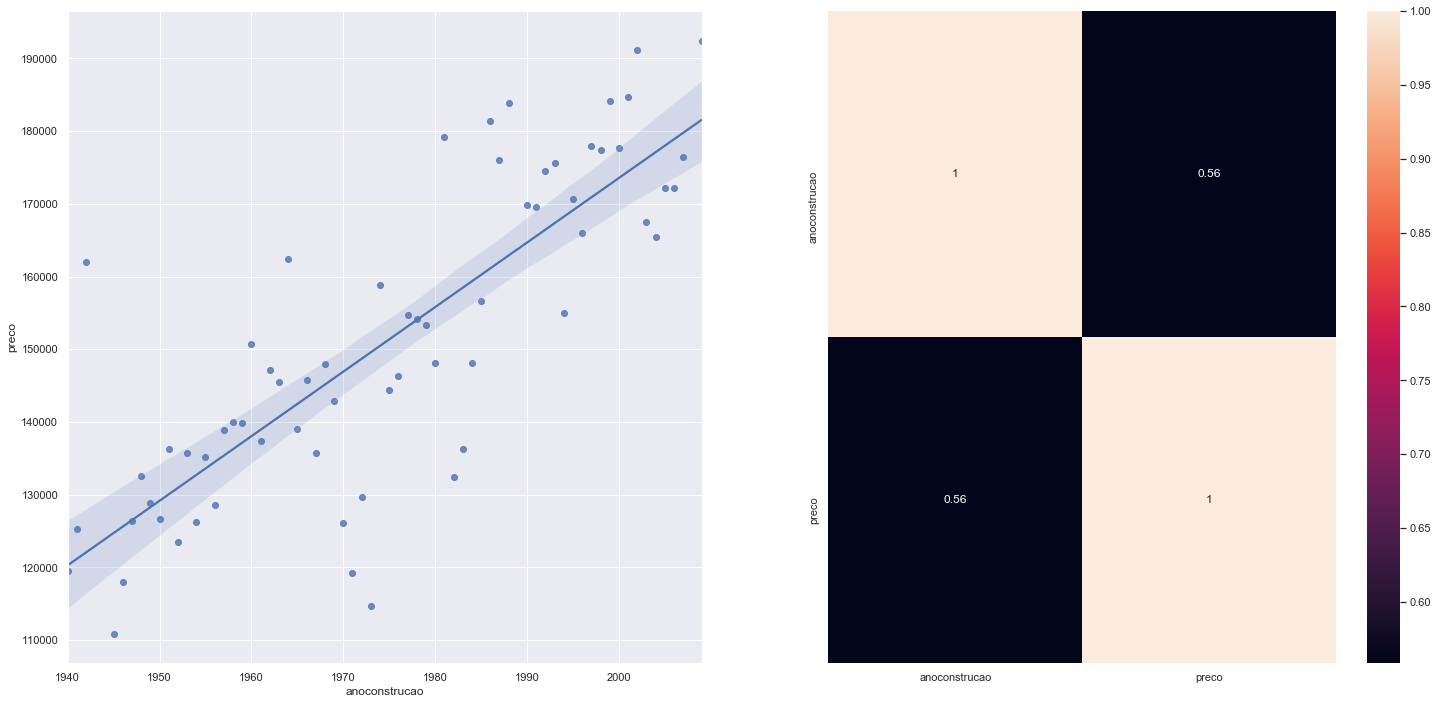

In [118]:
#regression plot
plt.subplot(1,2,1)
sns.regplot(x = "anoconstrucao", y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(df3[["anoconstrucao","preco"]].corr(method = "pearson"), annot = True)

- Imóveis mais novos costumam ser mais caros. No entanto, há alguns casos em que isso não é verdade. Acredito que seja importante futuramente analisar com mais afinco cada uma dessas exceções.

- Como podemos ver no gráfico de regressão, possuímos uma correlação positiva.

- A partir da correlação pearson, encontramos uma correlação de 0.56. Ou seja, uma correlação moderada bem próxima de forte. Acredito que essa será uma variável importante para o modelo.

- Hipótese verdadeira.

###  **H3** Imóveis localizados em regiões mais populosas devem ser mais caros.

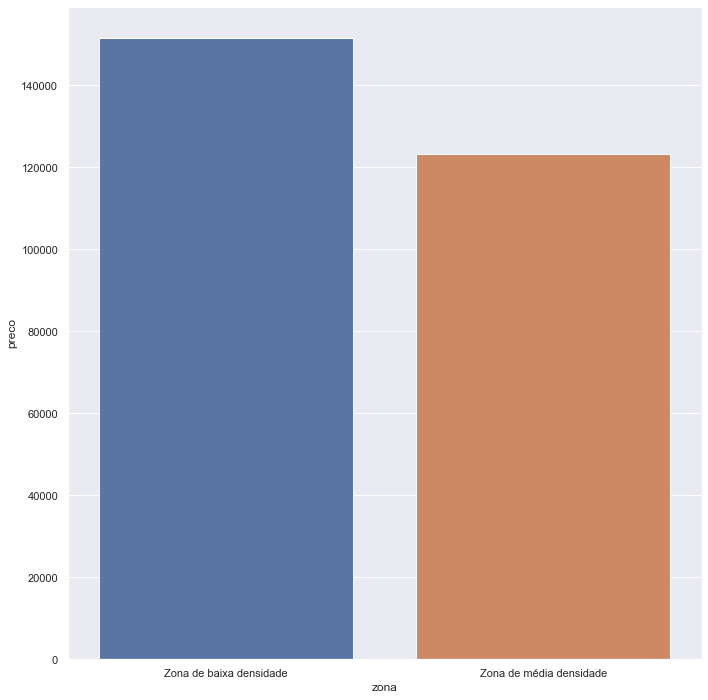

In [119]:
aux = df3[["zona","preco"]].groupby("zona").mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = "zona", y = "preco", data = aux)

- Hipótese falsa. Zona de baixa densidade possui imóveis com média de preços mais elevada.

### H4 Imóveis que possuem garagem devem ser mais caros.

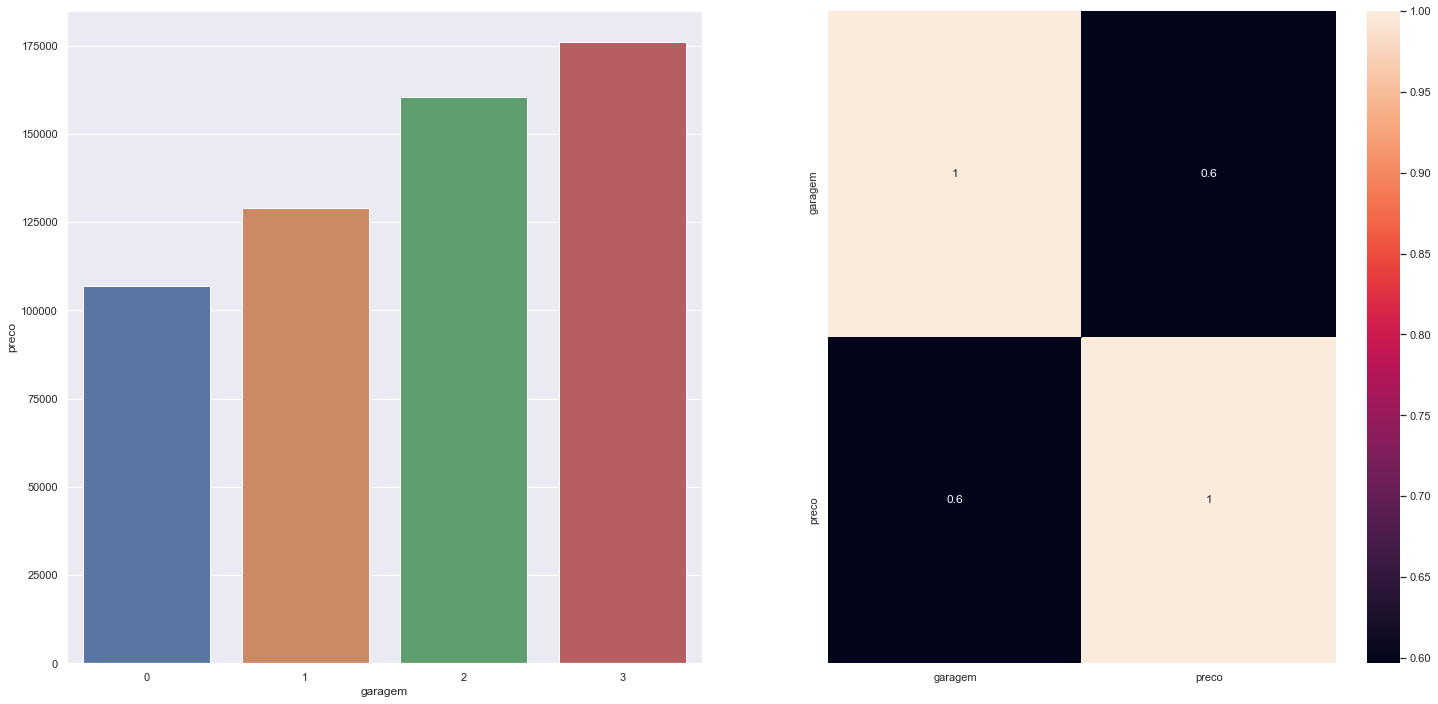

In [120]:
aux = df3[["garagem","preco"]].groupby("garagem").mean().reset_index()

#barplot
plt.subplot(1,2,1)
sns.barplot(x = "garagem",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(df3[["garagem", "preco"]].corr(method = "pearson"), annot = True)

- Hipótese verdadeira. Imóveis com mais vagas disponíveis para carros na garagem costumam ser mais caros.

- A partir do mapa de calor, verificamos que há uma correlação forte positiva entre a variável garagem e a variável preco

### H5 Imóveis com mais cômodos devem ser mais caros.

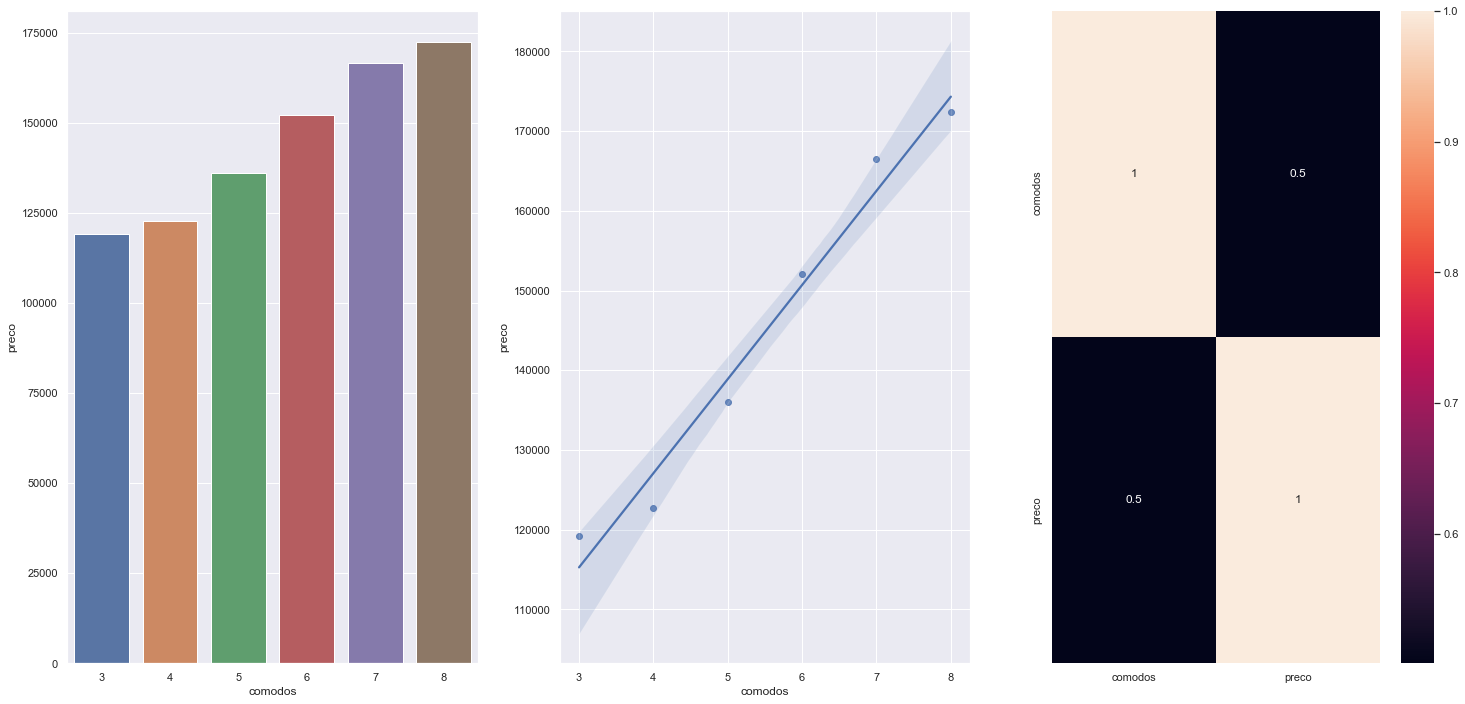

In [121]:
aux = df3[["comodos","preco"]].groupby("comodos").mean().reset_index()

#barplot
plt.subplot(1,3,1)
sns.barplot(x = "comodos",y = "preco", data = aux)

#regplot
plt.subplot(1,3,2)
sns.regplot(x = "comodos",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df3[["comodos", "preco"]].corr(method = "pearson"), annot = True)

- Hipótese verdadeira. Imóveis com mais cômodos costumam ser mais caros.

- Provável que essa variável funcione muito bem com a variável area. 

- A partir do mapa de calor, verificamos que há uma correlação forte positiva entre a variável comodos e a variável preco.

### H6 Imóveis com mais quartos devem ser mais caros

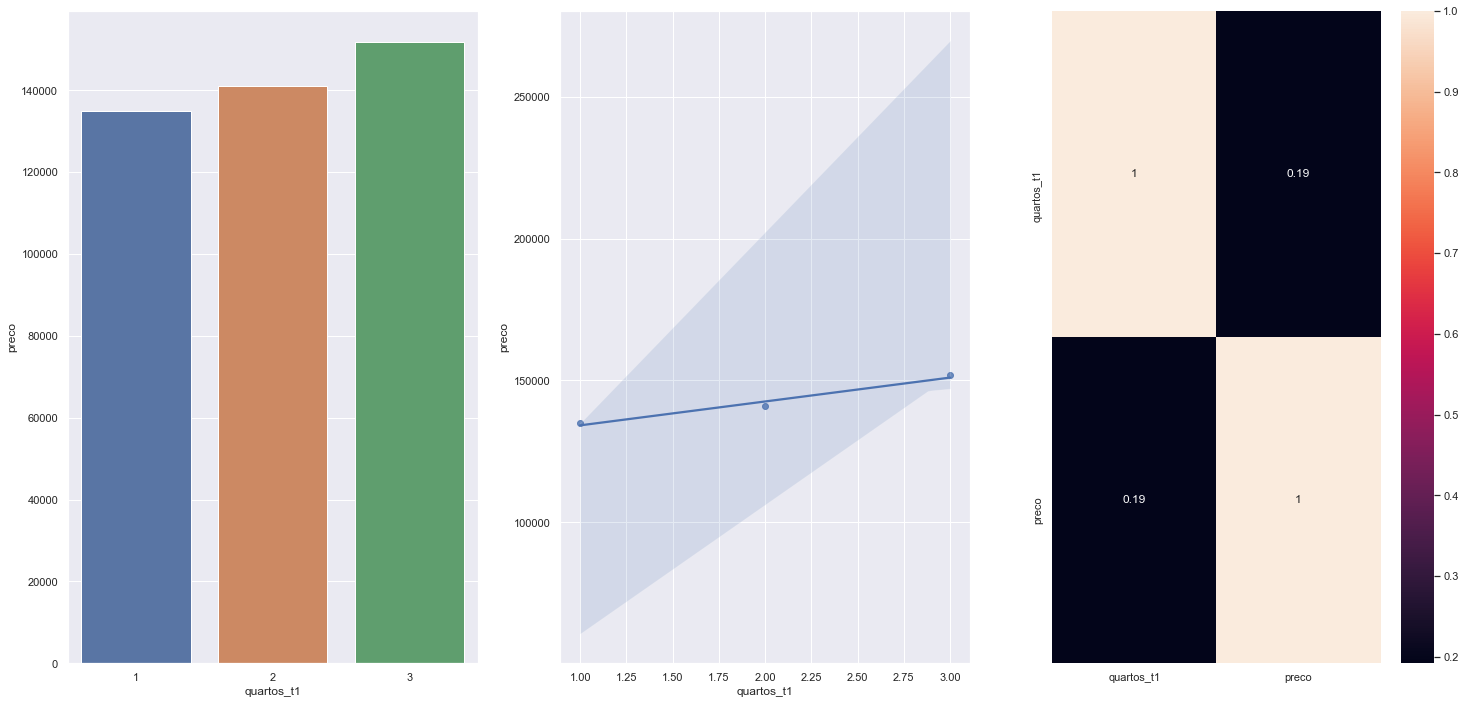

In [122]:
aux = df3[["quartos_t1","preco"]].groupby("quartos_t1").mean().reset_index()

#barplot
plt.subplot(1,3,1)
sns.barplot(x = "quartos_t1",y = "preco", data = aux)

#regplot
plt.subplot(1,3,2)
sns.regplot(x = "quartos_t1",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df3[["quartos_t1", "preco"]].corr(method = "pearson"), annot = True)

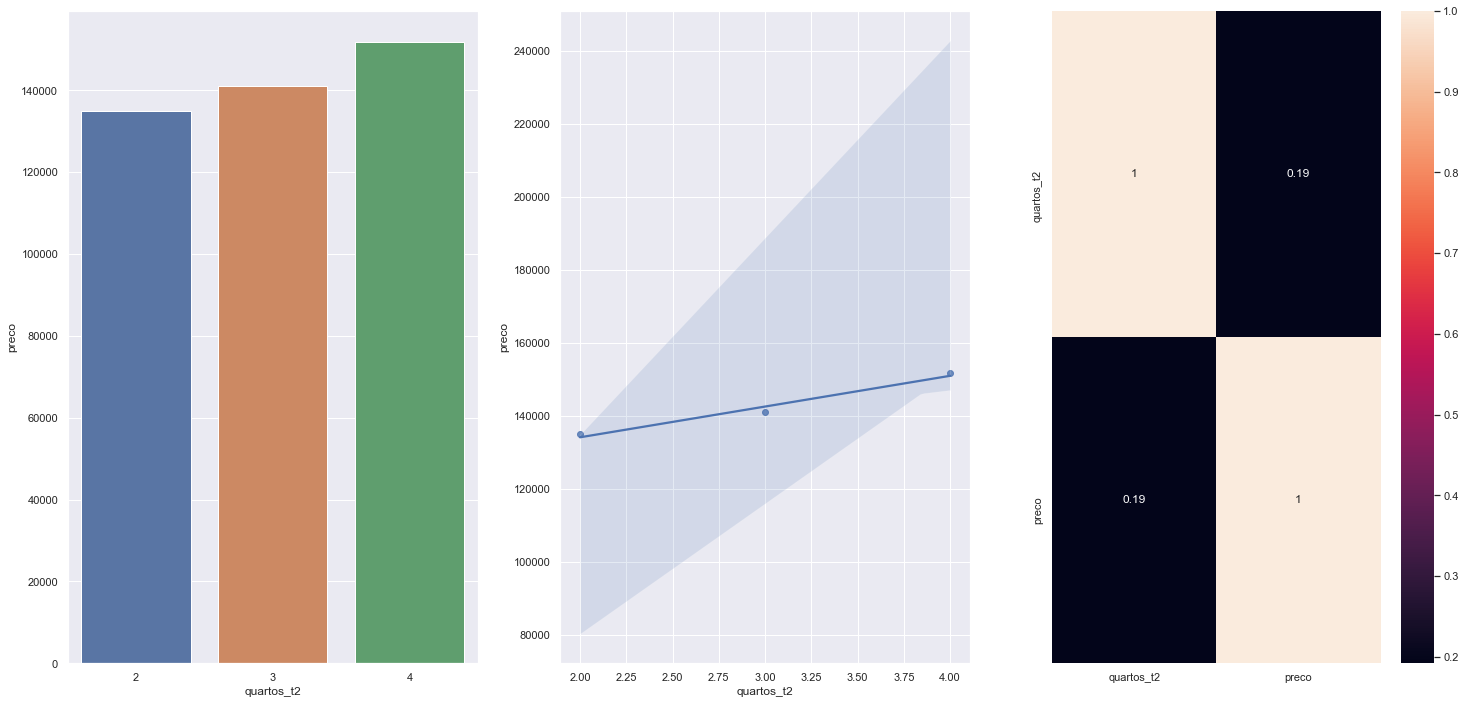

In [123]:
aux = df3[["quartos_t2","preco"]].groupby("quartos_t2").mean().reset_index()

#barplot
plt.subplot(1,3,1)
sns.barplot(x = "quartos_t2",y = "preco", data = aux)

#regplot
plt.subplot(1,3,2)
sns.regplot(x = "quartos_t2",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df3[["quartos_t2", "preco"]].corr(method = "pearson"), annot = True)

- Em ambos tipos de quartos, podemos encontrar uma tendência crescente. Ou seja, quanto mais quarto, mais caro o imóvel será. 

- No entanto, quando olhamos o gráfico de regressão e o mapa de calor, obtemos uma correlação positiva fraca de 0.19.

- Portanto, a hipótese é verdadeira.

### H7 Imóveis com possuem lareira devem ser mais caros.

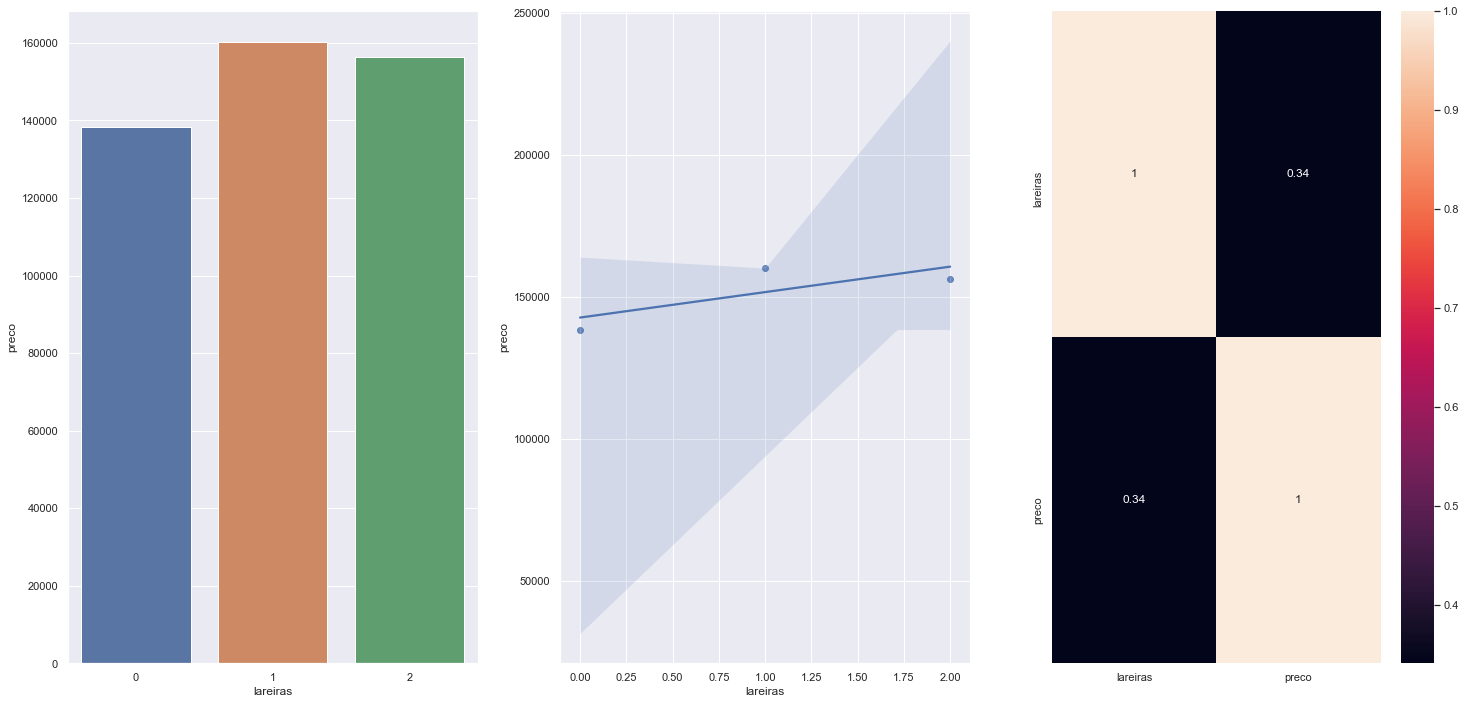

In [124]:
aux = df3[["lareiras","preco"]].groupby("lareiras").mean().reset_index()

#barplot
plt.subplot(1,3,1)
sns.barplot(x = "lareiras",y = "preco", data = aux)

#regplot
plt.subplot(1,3,2)
sns.regplot(x = "lareiras",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df3[["lareiras", "preco"]].corr(method = "pearson"), annot = True)

- Quando olhamos o gráfico de regressão e o mapa de calor, obtemos uma correlação positiva fraca/média de 0.34.A média de preços de imóveis com 2 lareiras é menor do que com apenas 1. 

- Portanto,a hipótese é falsa. 

### H8 Imóveis com excelente qualidade de acabamento devem ser mais caros.

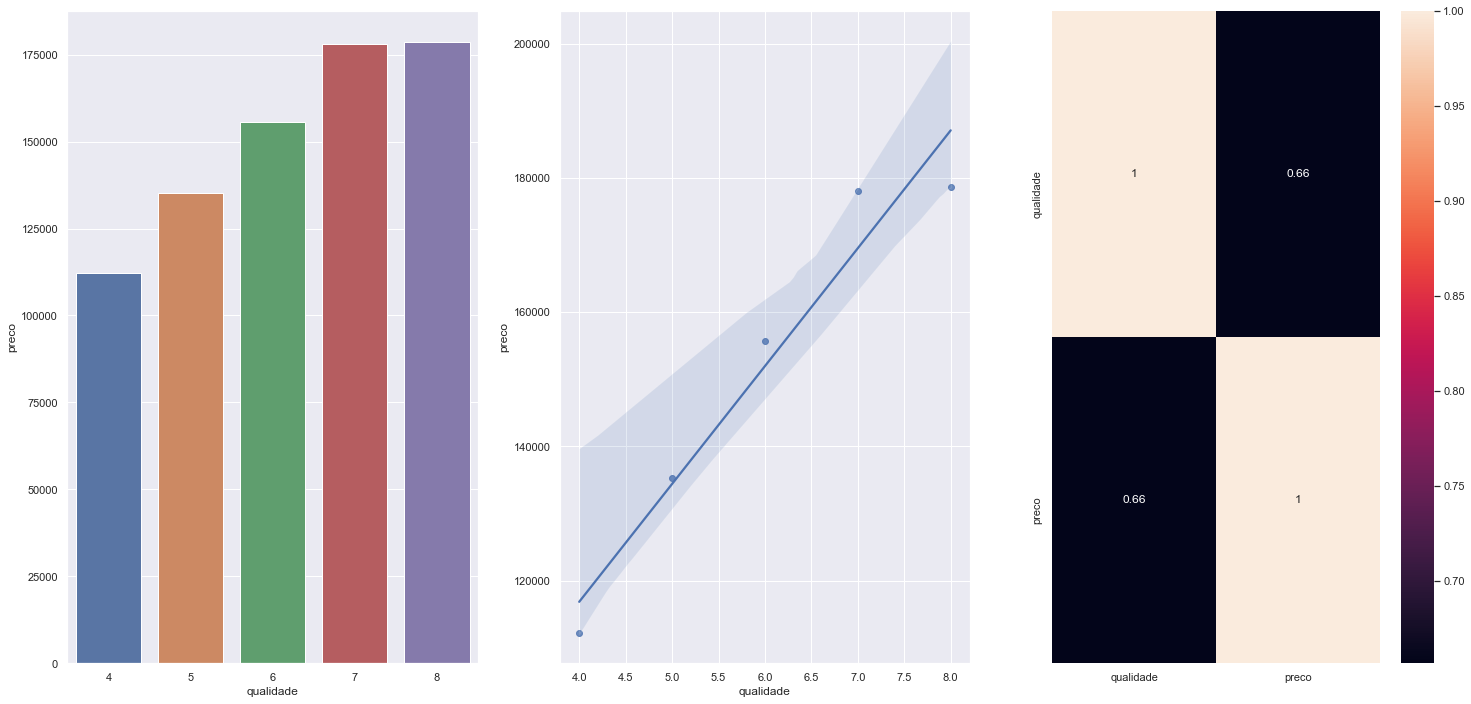

In [125]:
aux = df3[["qualidade","preco"]].groupby("qualidade").mean().reset_index()

#barplot
plt.subplot(1,3,1)
sns.barplot(x = "qualidade",y = "preco", data = aux)

#regplot
plt.subplot(1,3,2)
sns.regplot(x = "qualidade",y = "preco", data = aux)

#correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(df3[["qualidade", "preco"]].corr(method = "pearson"), annot = True)

- A médida que o nível de qualidade aumenta, o preço aumenta. Exceto nos de nível 7 e 8 que estão muito próximo. 

- Observamos no gráfico de regressão e correlação, uma forte tendência crescente. Encontramos uma correlação positiva moderada/forte de 0.66.

### H9 H9 Imóveis com boa qualidade do sistema de aquecimento.

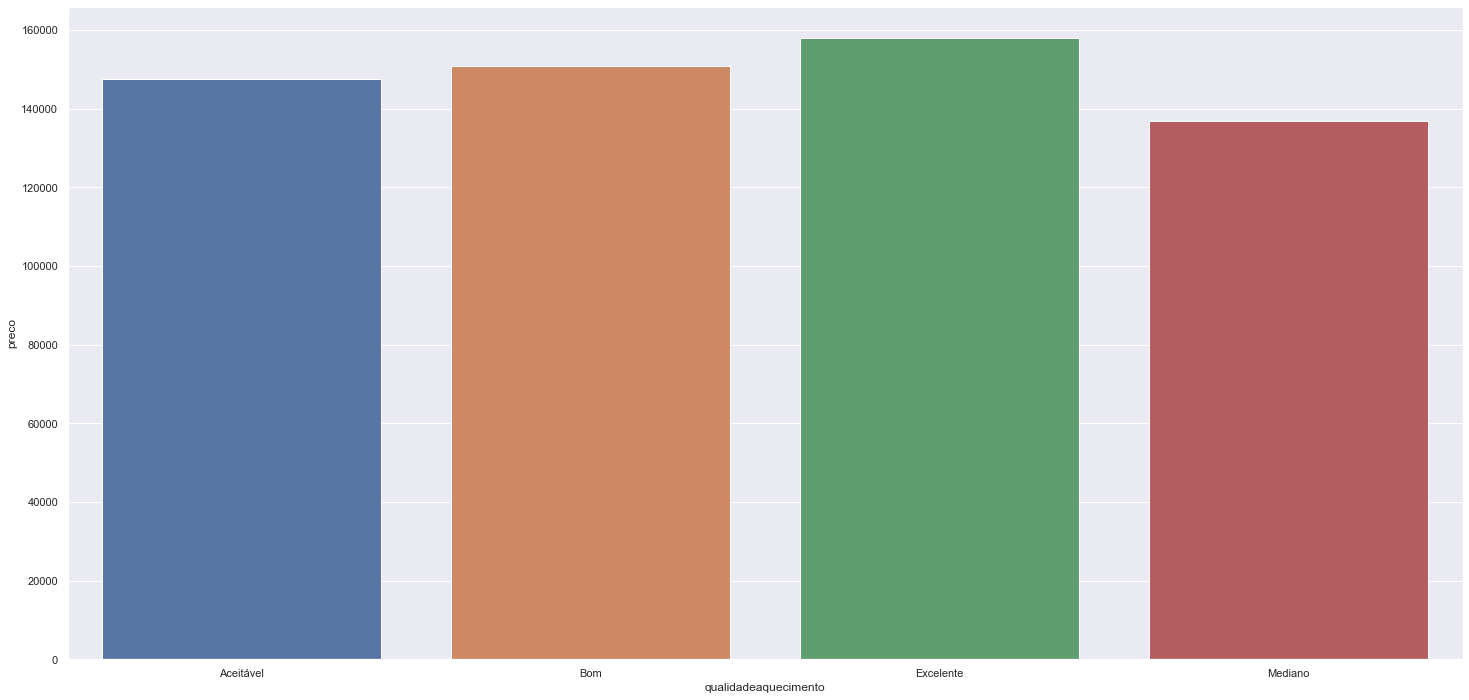

In [126]:
aux = df3[["qualidadeaquecimento","preco"]].groupby("qualidadeaquecimento").mean().reset_index()

#barplot
sns.barplot(x = "qualidadeaquecimento",y = "preco", data = aux)

In [127]:
aux.sort_values("preco", ascending = False)

,qualidadeaquecimento,preco
2,Excelente,157942.835294
1,Bom,150893.896552
0,Aceitável,147570.833333
3,Mediano,136949.430894


- Como visto acima, quanto maior a qualidade do sistema de aquecimento, maior o preço da cara. 

- É provável que os imóveis do dataset estejam localizados em países mais frios.

- Portanto, a hipótese é verdadeira.

## 3.3. Análise Multivariada

Essa etapa será realizada porque os algoritmos de aprendizado de máquina assumem algumas premissas, entre elas, o princípio da navalha de Occam. A regra de Ockham está associada ao requisito de reconhecer, para cada objeto analisado, apenas uma explicação suficiente.

Utilizamos os conceitos de dependência linear, ou seja, vamos supor que temos duas colunas que são linearmente dependentes, ou seja, cuja influência no problema é semelhante, podemos presumir que o efeito será mantido. Para descobrir isso, podemos olhar para a correlação entre variáveis ​​como uma alternativa para que possamos reduzir a dimensionalidade de nosso conjunto de dados.

Esta etapa será dividida em duas:

- Atributos numéricos
- Atributos categóricos

Vamos usar essa estratégia porque a análise multivariada de nossas variáveis ​​será diferente. Ou seja, para verificar a correlação entre as variáveis ​​numéricas, utilizaremos o método de Pearson e para as variáveis ​​categóricas, o método V de Cramér.

### 3.3.1. Atributos Numéricos

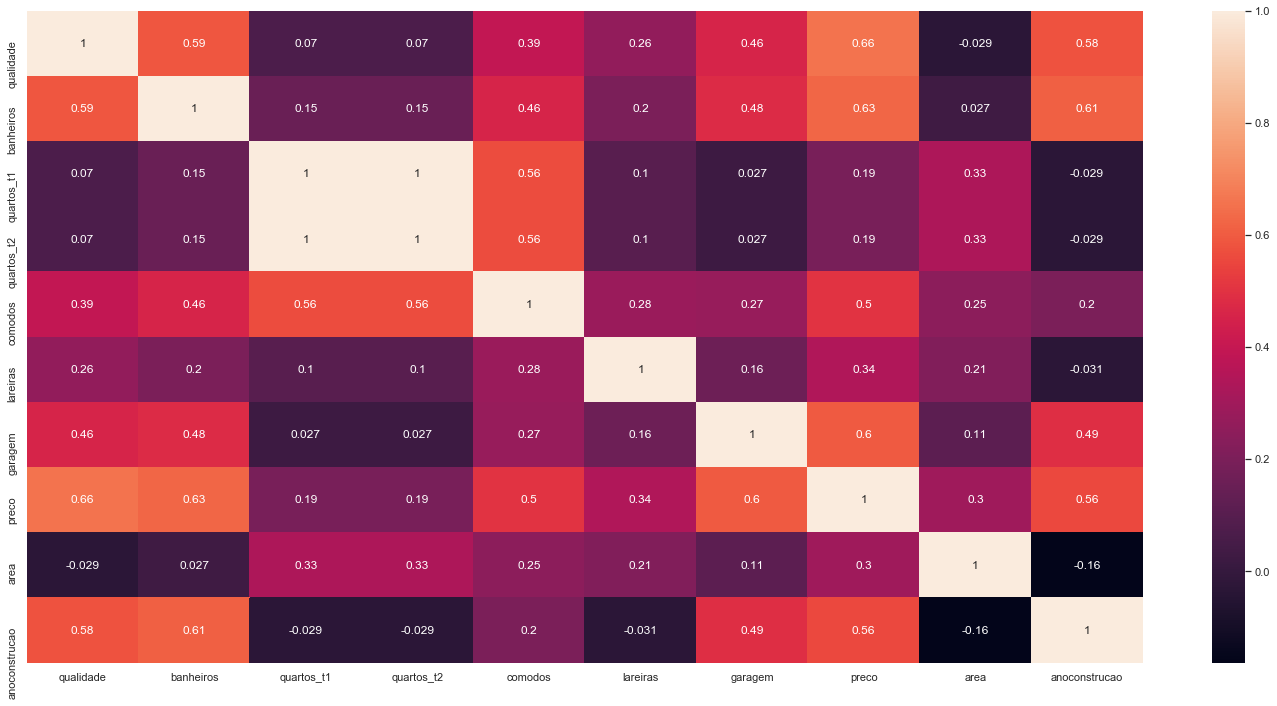

In [128]:
num_attributes = df3[["qualidade","banheiros","quartos_t1","quartos_t2","comodos","lareiras","garagem","preco","area","anoconstrucao"]]

sns.heatmap(num_attributes.corr(method = "pearson"), annot = True)

Observandos os valores, não encontramos variáveis linearmente dependentes. Portanto, até agora, manteremos todas as colunas.

### 3.3.2. Categorical Attributes

Em estatística, o V de Cramér (às vezes referido como phi de Cramér e denotado como φc) é uma medida de associação entre duas variáveis nominais, dando um valor entre 0 e +1 (inclusive). Dê uma olhada nas fórmulas abaixo.

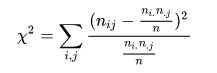

In [129]:
Image("image/CRAMER1.PNG")

O V de Cramér é calculado tomando a raiz quadrada do qui-quadrado dividido pelo tamanho da amostra e a dimensão mínima menos 1:

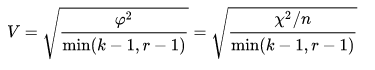

In [130]:
Image("image/CRAMER2.PNG")

O V de Cramér pode ser um estimador fortemente tendencioso de sua contraparte populacional e tenderá a superestimar a força da associação. Uma correção de viés, usando a notação acima, é dada por

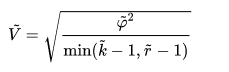

In [131]:
Image("image/CREAMER3.PNG")

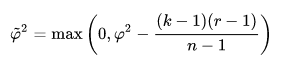

In [132]:
Image("image/CRAMER4.PNG")

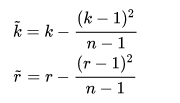

In [133]:
Image("image/CRAMER5.PNG")

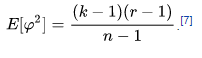

In [134]:
Image("image/CRAMER6.PNG")

Referências: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [135]:
aux = df3[["zona","qualidadeaquecimento"]]

In [136]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

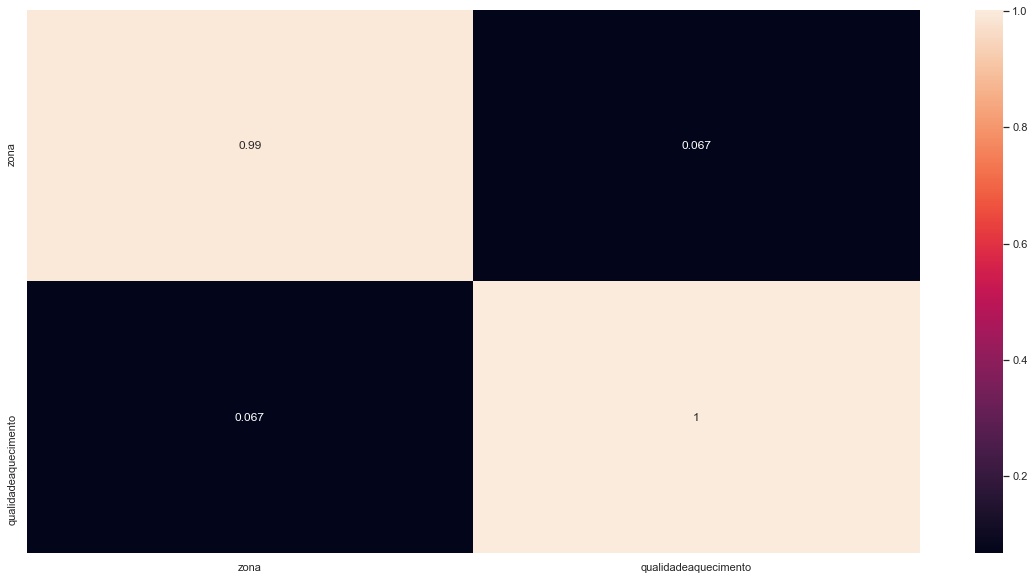

In [137]:
a1 = cramer_v(df3["zona"], df3["zona"])
a2 = cramer_v(df3["zona"], df3["qualidadeaquecimento"])

a3 = cramer_v(df3["qualidadeaquecimento"], df3["zona"])
a4 = cramer_v(df3["qualidadeaquecimento"], df3["qualidadeaquecimento"])

d = pd.DataFrame({'zona': [a1,a2],
              'qualidadeaquecimento': [a3,a4]})

d = d.set_index(d.columns)
plt.figure(figsize = (20,10))
sns.heatmap(d, annot = True)

Como visto acima, encontramos quase nenhuma correlação entre as variáveis "zona" e "qualidadeaquecimento".

# 4.0. DATA PREPARATION

In [26]:
df4 = df3.copy()

## 4.1. Split dos dados em treino e teste.

In [27]:
#retirando coluna "id"
df4.drop(columns = ["id"], axis = 1, inplace = True)

#Variáveis preditoras
X = df4.drop(columns = ["preco"], axis = 1)

#Variável Target
y = df4["preco"]

#seperando dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 42)

In [30]:
X_train = X_train[["area","qualidade","anoconstrucao","banheiros","comodos","lareiras","garagem"]]
X_test = X_test[["area","qualidade","anoconstrucao","banheiros","comodos","lareiras","garagem"]]

In [37]:
#definindo modelo e treinando modelo
rf_tuned_1 = RandomForestRegressor(n_estimators = 2000,
 min_samples_split= 5,
 min_samples_leaf = 1,
 max_features= "sqrt",
 max_depth = 10,
 bootstrap = True).fit(X_train,y_train)
                                 
                
#realizando a predição
yhat_rf_tuned = rf_tuned_1.predict(X_test)

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor',  y_test,yhat_rf_tuned)
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,10282.033232,0.075922,13692.709895


In [39]:
pickle.dump(rf_tuned_1, open("C:\\Users\\55819\\PycharmProjects\\model.pkl","wb"))

## 4.2. Normalização e Rescaling

- Normalização -> Se a média populacional e o desvio padrão populacional forem conhecidos, uma pontuação bruta x é convertida em um valor padrão por: Z = (x - mean)/std. É bom aplicá-lo quandi há uma distribuição normal em nossa variáveis.

- Rescaling -> Verificaremos quais variáveis possuem um alto número de outliers. Se encontrado, usaremos o RobustScaler com melhor desempenho para essas variáveis, pois usará quartis em vez de máximo e mínimo.Para variáveis que não possuem outliers, usaremos MinMaxScaler.

In [97]:
df4.head()

,zona,area,qualidade,anoconstrucao,qualidadeaquecimento,banheiros,quartos_t1,quartos_t2,comodos,lareiras,garagem,preco
0,Zona de baixa densidade,9600,6,1976,Excelente,2,3,4,6,1,2,181500
1,Zona de baixa densidade,14115,5,1993,Excelente,1,1,2,5,0,2,143000
2,Zona de baixa densidade,11200,5,1965,Excelente,1,3,4,5,0,1,129500
3,Zona de baixa densidade,12968,5,1962,Mediano,1,2,3,4,0,1,144000
4,Zona de baixa densidade,10920,6,1960,Mediano,1,2,3,5,1,1,157000


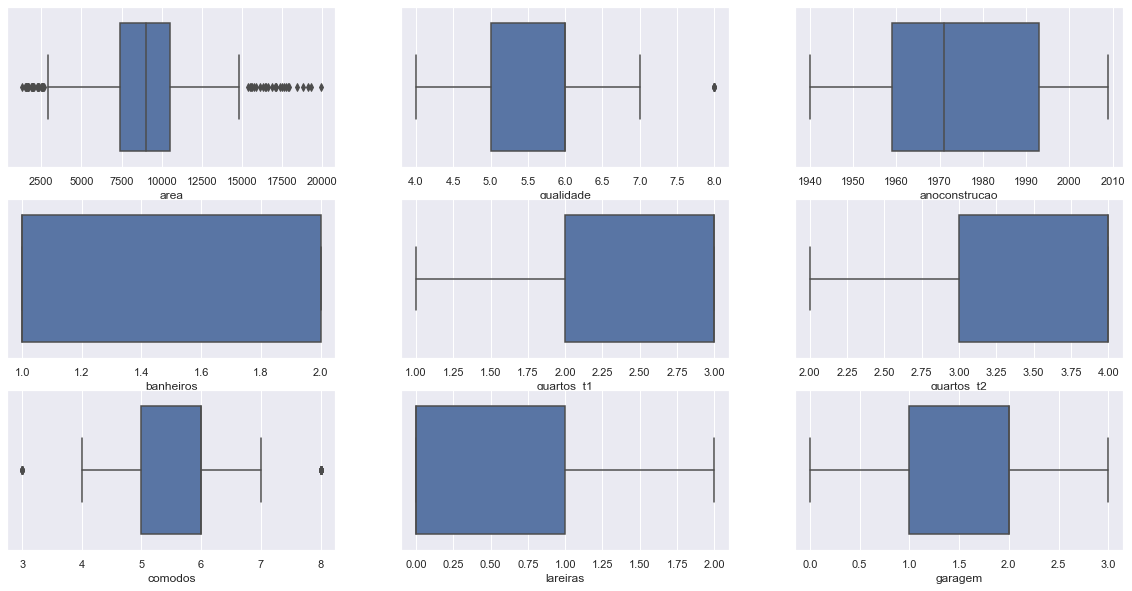

In [98]:
plt.figure(figsize = (20,10))
plt.subplot(3,3,1)
sns.boxplot(df3["area"]) #RobustScaler

plt.subplot(3,3,2)
sns.boxplot(df3["qualidade"]) #MinMaxScaler

plt.subplot(3,3,3)
sns.boxplot(df3["anoconstrucao"]) #MinMaxScaler

plt.subplot(3,3,4)
sns.boxplot(df3["banheiros"]) #MinMaxScaler

plt.subplot(3,3,5)
sns.boxplot(df3["quartos_t1"]) #MinMaxScaler

plt.subplot(3,3,6)
sns.boxplot(df3["quartos_t2"]) #MinMaxScaler

plt.subplot(3,3,7)
sns.boxplot(df3["comodos"]) #MinMaxScaler

plt.subplot(3,3,8)
sns.boxplot(df3["lareiras"]) #MinMaxScaler

plt.subplot(3,3,9)
sns.boxplot(df3["garagem"]) #MinMaxScaler

A partir dos boxplot acima, podemos entender que nosso dataset não possui muitas anomalias. A única coluna que apresenta outliers significativos é a coluna area. Nela, iremos usar o RobustScaler, no outros usaremos o MinMaxScaler

Mas antes, vamos verificar se há uma distribuição normal.

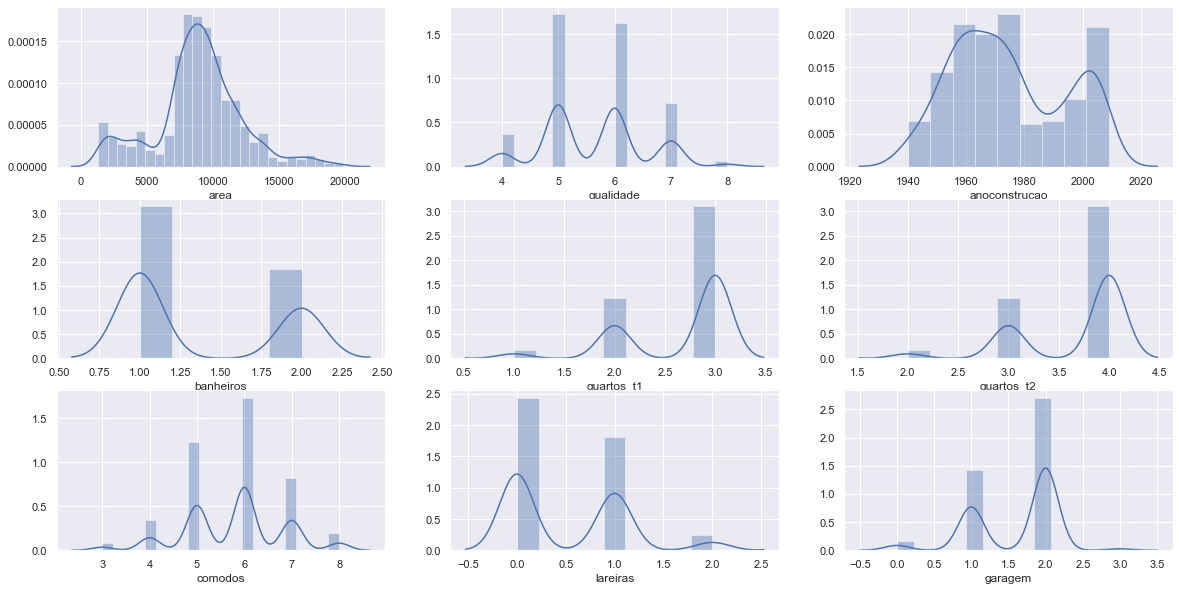

In [99]:
plt.figure(figsize = (20,10))
plt.subplot(3,3,1)
sns.distplot(df3["area"]) 

plt.subplot(3,3,2)
sns.distplot(df3["qualidade"]) 

plt.subplot(3,3,3)
sns.distplot(df3["anoconstrucao"]) 

plt.subplot(3,3,4)
sns.distplot(df3["banheiros"]) 

plt.subplot(3,3,5)
sns.distplot(df3["quartos_t1"]) 

plt.subplot(3,3,6)
sns.distplot(df3["quartos_t2"]) 

plt.subplot(3,3,7)
sns.distplot(df3["comodos"]) 

plt.subplot(3,3,8)
sns.distplot(df3["lareiras"]) 

plt.subplot(3,3,9)
sns.distplot(df3["garagem"]) 

Como não há distribuições normais, usaremos técnnicas de rescaling. Para tal, observe que não vamos usar o comando "fit" nos dados de treino, isso evitará um fenômeno chamado "Data Leakage", também conhecido por "vazamento de dados". 

In [100]:
#instanciando robustscaler e o minmaxsclaer
rs = RobustScaler()
mms = MinMaxScaler()

#area - RobustScaler
X_train["area"] = rs.fit_transform(X_train[["area"]].values)
pickle.dump(rs, open("parameter/area.pkl",'wb'))
X_test["area"] = rs.transform(X_test[["area"]].values)

#qualidade - MinMaxScaler
X_train["qualidade"] = mms.fit_transform(X_train[["qualidade"]].values)
pickle.dump(mms, open("parameter/qualidade.pkl",'wb'))
X_test["qualidade"] = mms.transform(X_test[["qualidade"]].values)

#anoconstrucao - MinMaxScaler
X_train["anoconstrucao"] = mms.fit_transform(X_train[["anoconstrucao"]].values)
pickle.dump(mms, open("parameter/anoconstrucao.pkl",'wb'))
X_test["anoconstrucao"] = mms.transform(X_test[["anoconstrucao"]].values)

#banheiros - MinMaxScaler
X_train["banheiros"] = mms.fit_transform(X_train[["banheiros"]].values)
pickle.dump(mms, open("parameter/banheiros.pkl",'wb'))
X_test["banheiros"] = mms.transform(X_test[["banheiros"]].values)

#quartos_t1 - MinMaxScaler
X_train["quartos_t1"] = mms.fit_transform(X_train[["quartos_t1"]].values)
pickle.dump(mms, open("parameter/quartos_t1.pkl",'wb'))
X_test["quartos_t1"] = mms.transform(X_test[["quartos_t1"]].values)

#quartos_t2 - MinMaxScaler
X_train["quartos_t2"] = mms.fit_transform(X_train[["quartos_t2"]].values)
pickle.dump(mms, open("parameter/quartos_t2.pkl",'wb'))
X_test["quartos_t2"] = mms.transform(X_test[["quartos_t2"]].values)

#comodos - MinMaxScaler
X_train["comodos"] = mms.fit_transform(X_train[["comodos"]].values)
pickle.dump(mms, open("parameter/comodos.pkl",'wb'))
X_test["comodos"] = mms.transform(X_test[["comodos"]].values)

#garagem - MinMaxScaler
X_train["garagem"] = mms.fit_transform(X_train[["garagem"]].values)
pickle.dump(mms, open("parameter/garagem.pkl",'wb'))
X_test["garagem"] = mms.transform(X_test[["garagem"]].values)

#lareiras - MinMaxScaler
X_train["lareiras"] = mms.fit_transform(X_train[["lareiras"]].values)
pickle.dump(mms, open("parameter/lareiras.pkl",'wb'))
X_test["lareiras"] = mms.transform(X_test[["lareiras"]].values)

Também precisamos verificar a nossa variável target. 

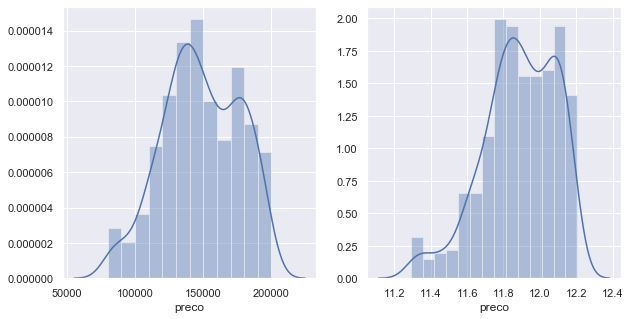

In [101]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.distplot(df4["preco"])

plt.subplot(1,2,2)
sns.distplot(np.log1p(df4["preco"]))

Aplicando uma transformação logarítimica, conseguimos diminuir o range de valores. Isso poderá evitar que o modelo superestime. 

In [102]:
#response variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

## 4.3. Encoding

**Label Enconder**

LabelEncoder é uma classe de utilitário para ajudar a normalizar rótulos de forma que contenham apenas valores entre 0 e n_classes-1. Isso às vezes é útil para escrever rotinas Cython eficientes. Também pode ser usado para transformar rótulos não numéricos em rótulos numéricos.

**One Hot Encoder**

Esse tipo de codificação pode ser obtido com o OneHotEncoder, que transforma cada recurso categórico com valores possíveis de n_categories em recursos binários de ncategories, sendo um deles 1 e todos os outros 0. Por padrão, os valores que cada recurso pode assumir são inferidos automaticamente do conjunto de dados e podem ser encontrados no atributo categorias.

**Ordinal Encoder**

Para converter recursos categóricos em códigos inteiros, podemos usar o OrdinalEncoder. Este estimador transforma cada recurso categórico em um novo recurso de números inteiros (0 a n_categories - 1) conforme ordenado.

Possuímos apenas duas variáveis categóricas, são elas: zona e qualidadeaquecimento. Resolveremos da seguinte forma:

- zona -> One Hot Encoder -> Apesar de criar mais uma coluna, não queremos incluir um viés nos dados. Portanto, acredito ser mais seguro.

- qualidadeaquecimento -> Label encoder -> Não queremos criar 4 colunas novas, portanto, usaremos o label encoder sabendo que poderemos criar um viés.

In [103]:
le = LabelEncoder()

#zona - OneHotEncoding
X_train = pd.get_dummies(X_train, prefix = ['zona'], columns = ['zona'])
X_test = pd.get_dummies(X_test, prefix = ['zona'], columns = ['zona'])

#qualidadeaquecimento - LabelEncoder
X_train["qualidadeaquecimento"] = le.fit_transform(X_train["qualidadeaquecimento"])
pickle.dump(le, open("parameter/qualidadeaquecimento.pkl",'wb'))
X_test["qualidadeaquecimento"] = le.transform(X_test["qualidadeaquecimento"])

In [104]:
#verificando como ficou nosso dataset
X_train.head()

,area,qualidade,anoconstrucao,qualidadeaquecimento,banheiros,quartos_t1,quartos_t2,comodos,lareiras,garagem,zona_Zona de baixa densidade,zona_Zona de média densidade
333,2.404290,0.75,0.884058,2,1.0,1.0,1.0,0.6,0.0,0.666667,1,0
6,1.549505,0.25,0.927536,2,0.0,1.0,1.0,0.6,0.0,0.666667,1,0
104,-2.415842,0.50,0.449275,3,0.0,0.5,0.5,0.4,0.0,0.333333,0,1
114,-0.198020,0.25,0.246377,3,0.0,1.0,1.0,0.4,0.0,0.333333,1,0
486,-0.330033,0.50,0.797101,1,1.0,1.0,1.0,1.0,0.5,0.666667,1,0


# 5.0. FEATURE SELECTION

## 5.1. Boruta as Feature Selector

O algoritmo Boruta é um wrapper construído em torno do algoritmo de classificação de floresta aleatória. Ele tenta capturar todos os recursos interessantes e importantes que você possa ter em seu conjunto de dados com relação a uma variável de resultado.

In [460]:
#training and test dataset for boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

#define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	2
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	7


In [461]:
cols_selected = boruta.support_.tolist()

#best features
x_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)
cols_selected_boruta

['area', 'qualidade', 'anoconstrucao', 'banheiros', 'garagem']

In [462]:
#armazenando as variáveis em uma lista
cols_selected_boruta = ['area', 'qualidade', 'anoconstrucao', 'banheiros', 'garagem']

## 5.2. Random Forest Regressor as Feature Selector

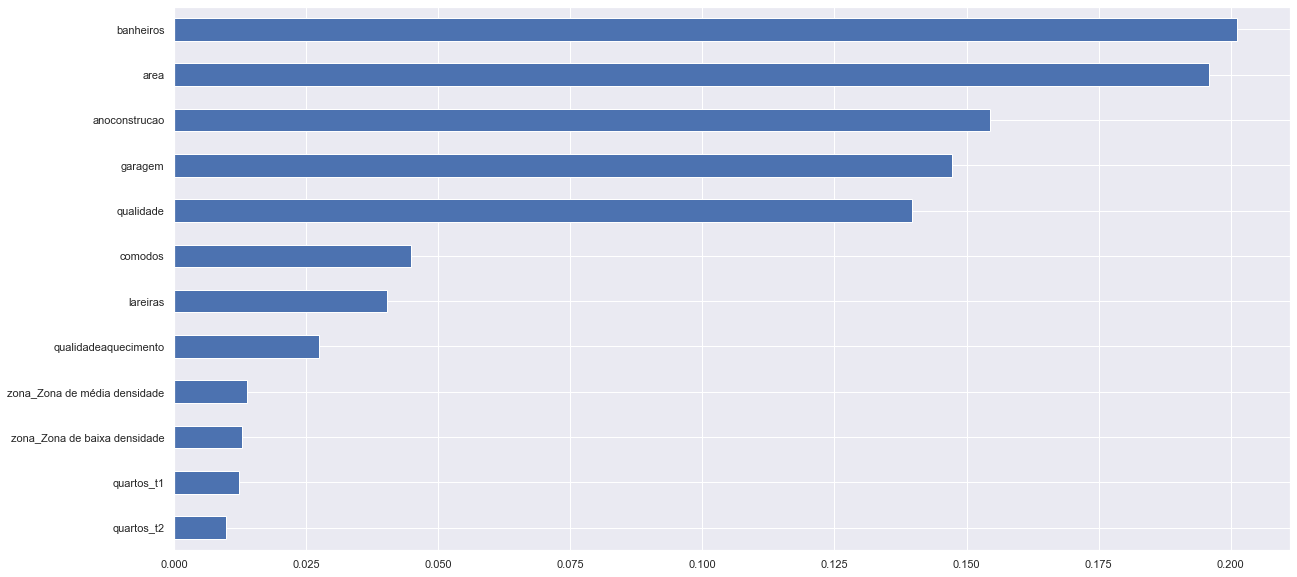

In [463]:
#feature importances 
rf_model = RandomForestRegressor(n_jobs = -1)
rf_model.fit(X_train, y_train.values)

feat_importances = pd.Series(rf_model.feature_importances_, index= X_train.columns)
plt.figure(figsize = (20,10))
feat_importances.sort_values().plot(kind='barh')

## 5.3. Recursive Feature Elimination (RFE)

In [464]:
#define model
rf = RandomForestRegressor(n_jobs = -1)

#feature selector
selector = RFE(rf, n_features_to_select = 7, step = 1)
selector = selector.fit(X_train,y_train)

#get ranking
selector.support_ 

array([ True,  True,  True, False,  True, False, False,  True,  True,
        True, False, False])

In [465]:
X_train.columns

Index(['area', 'qualidade', 'anoconstrucao', 'qualidadeaquecimento',
       'banheiros', 'quartos_t1', 'quartos_t2', 'comodos', 'lareiras',
       'garagem', 'zona_Zona de baixa densidade',
       'zona_Zona de média densidade'],
      dtype='object')

In [105]:
#armazenando colunas selecionadas pelo RFE
cols_selected_rfe = ["area","qualidade","anoconstrucao","banheiros","comodos","lareiras","garagem"]

# 6.0. MACHINE LEARNING MODELLING

Nesta seção, finalmente construiremos nossos modelos preditivos. Portanto, usaremos 4 algoritmos de aprendizado de máquina, que serão:

- Regressão linear (Baseline Model)
- Lasso
- Random Forest Regressor
- Regressor XGBoost

Para cada algoritmo, construiremos o que chamamos de técnica de validação cruzada. A validação cruzada é usada principalmente no aprendizado de máquina aplicado para estimar a habilidade de um modelo de aprendizado de máquina em dados não vistos. Ou seja, usar uma amostra limitada para estimar como o modelo deve funcionar em geral quando usado para fazer previsões sobre dados não usados durante o treinamento do modelo.

É um método popular porque é simples de entender e porque geralmente resulta em uma estimativa menos tendenciosa ou menos otimista da habilidade do modelo do que outros métodos, como uma divisão simples de treinamento / teste.

In [106]:
#Selecionando as colunas escolhidas pelo boruta
X_train = X_train[cols_selected_rfe]
X_test = X_test[cols_selected_rfe]

## 6.1. Linear Regression Model

In [468]:
#model
lr = LinearRegression().fit(X_train,y_train)

#prediction
yhat_lr = lr.predict(X_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,10861.177346,0.079793,14508.373071


### 6.1.1. Cross-Validation -> Linear Regression Model

Para que possamos separar os nossos dados em folds, iremos juntar novamente os dados de treino e teste.

In [469]:
#juntando os dados de treino e teste novamente
X = pd.concat([X_train,X_test]) #variáveis preditoras
y = pd.concat([y_train,y_test]) #variável target

Utilizaremos a função criada. Caso queira consultar, verifique na secção "Helper Functions". 

In [470]:
#cross_validation( X, y , kfold, model_name, model, verbose=True ) 
lr_result_cv = cross_validation(X,y,10,"Linear Regression", lr)
lr_result_cv


KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,11907.42 +/- 963.17,0.09 +/- 0.01,15500.2 +/- 1856.4


## 6.2. Linear Regression Regularized Model - Lasso

In [471]:
#model
lrr = Lasso(alpha = 0.01).fit(X_train,y_train)

#prediction
yhat_lrr = lrr.predict(X_test)

#performance
lrr_result = ml_error('Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,13150.782312,0.100504,17409.601518


### 6.2.1. Cross-Validation - Lasso

In [472]:
#Lasso with cross-validation
lrr_result_cv = cross_validation(X, y, 10, "Lasso",lrr)
lrr_result_cv


KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,14264.36 +/- 542.68,0.1 +/- 0.01,18300.35 +/- 402.2


## 6.3. Random Forest Regressor

In [473]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(X_train,y_train)

#prediction
yhat_rf = rf.predict(X_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,10486.417511,0.075467,14122.645588


### 6.3.1. Cross-Validation - Random Forest Regressor

In [474]:
#random forest with cross-validation
rf_result_cv = cross_validation(X, y, 10, "Random Forest Regressor", rf)
rf_result_cv


KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,12121.01 +/- 991.19,0.09 +/- 0.01,15959.75 +/- 1547.23


## 6.4. XGBoost Regressor

In [475]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,11480.827567,0.083088,15019.742368


### 6.4.1. Cross-Validation - XGBoost Regressor

In [476]:
#xgboost with cross-validation
xgb_result_cv = cross_validation(X, y , 10, "XGBoostRegressor", model_xgb)
xgb_result_cv


KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoostRegressor,12288.75 +/- 626.8,0.09 +/- 0.01,16623.65 +/- 1122.31


# 7.0. COMPARANDO PERFORMANCE DO MODELO

## 7.1. Single Performance

In [477]:
#ordenado pelo RMSE do menor para o maior.
modelling_result = pd.concat( [lr_result, lrr_result,rf_result,xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,10486.417511,0.075467,14122.645588
0,Linear Regression,10861.177346,0.079793,14508.373071
0,XGBoost Regressor,11480.827567,0.083088,15019.742368
0,Lasso,13150.782312,0.100504,17409.601518


## 7.2. Real Performance - Cross-Validation

In [478]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values("MAPE CV")

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,11907.42 +/- 963.17,0.09 +/- 0.01,15500.2 +/- 1856.4
0,Random Forest Regressor,12121.01 +/- 991.19,0.09 +/- 0.01,15959.75 +/- 1547.23
0,XGBoostRegressor,12288.75 +/- 626.8,0.09 +/- 0.01,16623.65 +/- 1122.31
0,Lasso,14264.36 +/- 542.68,0.1 +/- 0.01,18300.35 +/- 402.2


Como nosso modelo com melhor performance foi a Random Forest, precisamos entender o que as métricas significam.

- MAE -> Em média, nosso modelo irá errar 11796 com um desvio padrão de 577.42.
- MAPE -> Em média, nosso modelo irár errar 9% com um desvio padrão de 1%. Ou seja, pode variar entre 8% e 10%.
- RMSE -> É útil para nos guiar em obter a melhor performance do modelo. Portanto, no RMSE, os erros são mais gritantes. Obtivemos um erro médio de 15940 com desvio padrão de 805.05.  

# 8.0. HYPERPARAMETER FINE TUNING 

## 8.1. Random Search Cv

Para selecionar os melhores parâmetros, usaremos o RandomSearchCv. Ou seja, ele realizará uma busca aleatória,sorteando alguns pontos para serem visitados.

Dessa maneira você visitará várias áreas do possível espaço de combinações. Isso aumenta a chance de encontrar uma combinação próxima da melhor possível em bem menos tempo, comparado ao GridSearchCv.

Varia de caso para caso, mas na prática, visitando 50 a 100 pontos você já vai achar uma combinação muito próxima da ideal.Existem vários trabalhos acadêmicos e casos de uso que provam asuperioridade da random search sobre a grid search.Essa é uma das raras oportunidades de dizer que sabemos a superioridade de um método (random search) sobre outro método (grid search) na prática de data science.

In [401]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid  = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [403]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [404]:
#encontrando os melhores parâmetros
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

## 8.2. Treinando Random Forest com os melhores parâmetros.

In [107]:
#definindo modelo e treinando modelo
rf_tuned = RandomForestRegressor(n_estimators = 2000,
 min_samples_split= 5,
 min_samples_leaf = 1,
 max_features= "sqrt",
 max_depth = 10,
 bootstrap = True).fit(X_train,y_train)
                                 
                
#realizando a predição
yhat_rf_tuned = rf_tuned.predict(X_test)

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf_tuned ) )
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,10248.429383,0.074677,13664.392603


In [151]:
pickle.dump(rf_tuned, open("C:\ProjetosDataScience\casetecnico\model\model_rf.pkl","wb"))

# 9.0. DEPLOY MODEL TO PRODUCTION

- Criar classe -> price
- API Handler
- API Tester

## 9.1. Price Class

In [85]:
import pickle
import pandas as pd
import numpy as np

class Price(object):
    def __init__(self):
        
        self.__anoconstrucao   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/anoconstrucao.pkl', 'rb') )
        self.__area   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/area.pkl', 'rb') )
        self.__banheiros   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/banheiros.pkl', 'rb') )
        self.__comodos   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/comodos.pkl', 'rb') )
        self.__garagem   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/garagem.pkl', 'rb') )
        self.__lareiras   = pickle.load( open('C:/ProjetosDataScience/casetecnico/parameter/lareiras.pkl', 'rb') )
        self.__qualidade   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/qualidade.pkl', 'rb') )
        self.__quartos_t1   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/quartos_t1.pkl', 'rb') )
        self.__quartos_t2   = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/quartos_t2.pkl', 'rb') )
        self.__qualidadeaquecimento  = pickle.load(open('C:/ProjetosDataScience/casetecnico/parameter/qualidadeaquecimento.pkl','rb'))
        
        
    def data_cleaning(self, df1):
        #colunas extraidas do dataframe
           
        columns = ['Id', 'Zona', 'Area', 'Qualidade', 'AnoConstrucao',
           'QualidadeAquecimento', 'Banheiros', 'Quartos_t1', 'Quartos_t2',
            'Comodos', 'Lareiras', 'Garagem', 'Preco']

        #lista vazia para armazerar o nome das novas colunas
        new_columns = []
        
        #loop for para transformar cada columa em lowercase
        for each_column in columns:
            new_columns.append(each_column.lower())
    
        #mudando nome das colunas
        df1.columns = new_columns

        return df1
        
    def feature_engineering(self, df2):
        #qualidade de aquecimento
        df2['qualidadeaquecimento'] = df2['qualidadeaquecimento'].apply(lambda x:"Excelente" if x == "Ex" else "Bom" if x == "Gd" else "Mediano" if x == "TA" else "Aceitável")

        #zona
        df2['zona'] = df2['zona'].apply(lambda x: "Zona de baixa densidade" if x == "RL" else "Zona de média densidade")
            
        return df2
        
    def data_preparation(self, df3):
        #retirando coluna "id"
        df3.drop(columns = ["id"], axis = 1, inplace = True)
            
        #normalization and rescaling
        #area - RobustScaler
        df3["area"] = self.__area.fit_transform(df3[["area"]].values)

        #qualidade - MinMaxScaler
        df3["qualidade"] = self.__qualidade.fit_transform(df3[["qualidade"]].values)

            #anoconstrucao - MinMaxScaler
        df3["anoconstrucao"] = self.__anoconstrucao.fit_transform(df3[["anoconstrucao"]].values)

            #banheiros - MinMaxScaler
        df3["banheiros"] = self.__banheiros.fit_transform(df3[["banheiros"]].values)

            #quartos_t1 - MinMaxScaler
        df3["quartos_t1"] = self.__quartos_t1.fit_transform(df3[["quartos_t1"]].values)

            #quartos_t2 - MinMaxScaler
        df3["quartos_t2"] = self.__quartos_t2.fit_transform(df3[["quartos_t2"]].values)

            #comodos - MinMaxScaler
        df3["comodos"] = self.__comodos.fit_transform(df3[["comodos"]].values)

            #garagem - MinMaxScaler
        df3["garagem"] = self.__garagem.fit_transform(df3[["garagem"]].values)

            #lareiras - MinMaxScaler
        df3["lareiras"] = self.__lareiras.fit_transform(df3[["lareiras"]].values)
            
            #ENCODING
            #zona - OneHotEncoding
        df3 = pd.get_dummies(df3, prefix = ['zona'], columns = ['zona'])

            #qualidadeaquecimento - LabelEncoder
        df3["qualidadeaquecimento"] = self.__qualidadeaquecimento.fit_transform(X_train["qualidadeaquecimento"])

            #Columns selected
            #armazenando colunas selecionadas pelo RFE
        cols_selected = ["area","qualidade","anoconstrucao","banheiros","comodos","lareiras","garagem"]
        
        df3 = df3[cols_selected]

        return df3
        
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json( orient='records', date_format='iso' )


## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response

#from pricehouses.Price import Price

#loading model
model = pickle.load(open("C:/ProjetosDataScience/casetecnico/model/model.pkl",'rb'))

app = Flask(__name__)
@app.route("/predict_price/predict", methods =['POST'])

def predict_price():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Price()
        print("Aqui")
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, df2, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '127.0.0.1', debug = True ) #local host

## 9.3. API Tester

In [158]:
import requests
import json
import pickle

In [194]:
#loading test dataset
test_data = df_raw.sample(10)
test_data.drop("Preco", axis =1 , inplace = True)

#a = test_data.to_dict(orient='records')
#convert dataframe to json
#data = json.dumps(a)
data = test_data.to_json(orient='records')
type(data)

str

In [195]:
data

'[{"Id":144,"Zona":"RL","Area":9042,"Qualidade":6,"AnoConstrucao":1998,"QualidadeAquecimento":"Gd","Banheiros":2,"Quartos_t1":3,"Quartos_t2":4,"Comodos":7,"Lareiras":2,"Garagem":2},{"Id":122,"Zona":"RL","Area":7917,"Qualidade":6,"AnoConstrucao":1976,"QualidadeAquecimento":"TA","Banheiros":1,"Quartos_t1":3,"Quartos_t2":4,"Comodos":6,"Lareiras":1,"Garagem":1},{"Id":246,"Zona":"RL","Area":7332,"Qualidade":6,"AnoConstrucao":1959,"QualidadeAquecimento":"Ex","Banheiros":1,"Quartos_t1":2,"Quartos_t2":3,"Comodos":4,"Lareiras":0,"Garagem":1},{"Id":526,"Zona":"RL","Area":10140,"Qualidade":5,"AnoConstrucao":1975,"QualidadeAquecimento":"Ex","Banheiros":1,"Quartos_t1":3,"Quartos_t2":4,"Comodos":6,"Lareiras":0,"Garagem":2},{"Id":294,"Zona":"RL","Area":2887,"Qualidade":6,"AnoConstrucao":1996,"QualidadeAquecimento":"Ex","Banheiros":1,"Quartos_t1":2,"Quartos_t2":3,"Comodos":6,"Lareiras":1,"Garagem":2},{"Id":216,"Zona":"RL","Area":7800,"Qualidade":5,"AnoConstrucao":1967,"QualidadeAquecimento":"Ex","Banh

In [197]:
#API call
url = 'http://127.0.0.1:5000//predict_price/predict'
header = {"Contet-type": 'application/json'}
data = data

#request
r = requests.post(url, data = data, headers = header)
print("Status Code {}".format(r.status_code))

Status Code 200


In [204]:
r.json()

{}

In [2]:
model = pickle.load(open("C:/ProjetosDataScience/casetecnico/model/model_rf.pkl", 'rb'))

In [53]:
cols_selected_rfe = ["area","qualidade","anoconstrucao","banheiros","comodos","lareiras","garagem"]

In [112]:
df = df_raw[["Area","Qualidade","AnoConstrucao","Banheiros","Comodos","Lareiras","Garagem"]]

In [159]:
predicao = X_test.sample(2)

In [160]:
yhat = model.predict(predicao)

In [161]:
np.expm1(yhat)

array([184254.46045129, 175903.83027103])